# 6. Supervised Learning - Classification Modelling
Author: Philip Kalinda

## 6.1 Intro

Here we will look at using classification modelling. This branch of data science can be applied in a number of ways. We will look at classifiying whether or not a product is going to be purchased in the next order given the current order.

In [269]:
# standards
import numpy as np
import pandas as pd

# vizulaisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
shopColors = ['#EC5D24','#93134A','#F7F5E8','#2B2C30','#336E7B','#F2931A']*2
from matplotlib.colors import LinearSegmentedColormap
cm = LinearSegmentedColormap.from_list('sains', shopColors, N=len(shopColors))
sns.set_palette(shopColors)

# settings
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 60)
pd.set_option("display.latex.repr", True)

In [270]:
np.random.seed(np.sum([ord(i) for i in 'PK']))

## 6.2 Product Selection

So we will start by choosing a product. Seeing as we would like to get as much data as we can, we will simply pick the most purchased item. Hopefully this should provide a decent sized dataset.

In [271]:
orderProductMatrix = pd.read_csv('datasets/orderProductMatrix.csv',index_col=0)

In [272]:
orderProductMatrix.T.sum(axis=1).sort_values(ascending=False).head(10)

5b1c832b259948b35fa18c6b22bd118dd45f08749b00d90efd9d250d22eb66cb    1590.0
b2ba2185b1b07a4f60816d81a868a7d7cd176088b6e1a789e409e39543a8550a    1283.0
8981a704b6bbaa5905426856431e9982ea7d8b3e16a0d72e29559083b5ac3a47     897.0
f2a050cc4c05b21e18bfb12d83bc35a024a8ef3421b973b5ffb972d819640ed0     846.0
526f666244e147c6b6c1937ce42bd727f298db5ace9fc8a4c8d792fb8c717fd2     767.0
e22967eef7d091fe5475af59c458053b9af34d93c11784201f44187c8d65b30d     760.0
a2879363924746b2955ac17cbb05957c4b6d3eb78f5cf00abe93bde41ee8d95d     568.0
de4bc3388194aa9a88a29b676d28e97b52d6c9ab5aad72fe58e509570d207cc5     557.0
ec6b07d32891755821a3701a44bafa86849516f23048c0a0861a9302bc226e00     552.0
e6c1e994a63e149c7f8f818afa6b474c45d89e412a59040bb2c80ced79319639     485.0
dtype: float64

Here we can see that the most purchased item from all the orders is "5b1c832b259948b35fa18c6b22bd118dd45f08749b00d90efd9d250d22eb66cb". so we will build a model to predict whether, based on the current order, this item will be purchased in the current customer's next order.

In [273]:
orderProductMatrix.loc[:,'5b1c832b259948b35fa18c6b22bd118dd45f08749b00d90efd9d250d22eb66cb'].fillna(0).value_counts()

0.0     10045
1.0       835
2.0       175
3.0        52
4.0        20
5.0        13
6.0        10
10.0        2
9.0         1
8.0         1
7.0         1
Name: 5b1c832b259948b35fa18c6b22bd118dd45f08749b00d90efd9d250d22eb66cb, dtype: int64

In [274]:
orderProductMatrix.loc[:,'5b1c832b259948b35fa18c6b22bd118dd45f08749b00d90efd9d250d22eb66cb'].fillna(0).value_counts()[1:].sum()

1110

In [275]:
del orderProductMatrix ## no longer required

Here we can see that most people order 1 of the item and this tails of as the quantity increases. So instead of having 1590 records, we will be working on the unique orders totalling 1110 with this product in their basket.

We will only consider if the product is ordered or not, developing a classification model instead of a regression model based on the quantity.

## 6.3 Dataset Build

### 6.3.1 Raw Data

Here we will read in the data that we have and we will generate an aggregated dataset with the orders being represented by a row in the data. 

We will read in the main data that we have from book 1 (the alteredRawData), the orders (which will be the core dataset upon which we will append), the customerClusters data from our 4th booklet "Unsupervised Learning - Clustering"(I think it would be interesting to see how effective clusters can be as we would expect to see differing behaviours in each of the clusters), the customers data and stores (both as built in Booklet 2: Dataset Building).

In [276]:
data = pd.read_csv('datasets/alteredRawData.csv',index_col=0)
orders = pd.read_csv('datasets/orders.csv',index_col=0)
customerClusters = pd.read_csv('datasets/customerClusters.csv',index_col=0)
customers = pd.read_csv('datasets/customers.csv', index_col=0)
stores = pd.read_csv('datasets/storesBase.csv', index_col=0)

### 6.3.2 Predictor Variables

Here we can join all the tables together and take out columns with respect to their source. So we can rename them so we know which varibale corresponds to each source.

In [277]:
finalData = orders.join(
    customers.set_index('customerID'), on='customerID', rsuffix='_customers')
finalData = finalData.join(
    customerClusters.set_index('customerID'), on='customerID', rsuffix='_customerClusters')
finalData = finalData.join(
    stores.set_index('storeID'), on='storeID', rsuffix='_stores')

In [278]:
iDs = [i for i in finalData.columns if 'ID' in i]
orderCols = [i for i in orders.columns if i not in iDs]
customerCols = [i for i in customers.columns if i not in orders.columns]
customerClustersCols = [i for i in customerClusters.columns if i not in orders.columns]
storeCols = [i for i in stores.columns if i not in orders.columns]

In [279]:
finalData.rename(index=str, columns={i:'order_'+i for i in orderCols},inplace=True)
finalData.rename(index=str, columns={i:'customer_'+i for i in customerCols},inplace=True)
finalData.rename(index=str, columns={i:'customerClust_'+i for i in customerClustersCols},inplace=True)
finalData.rename(index=str, columns={i:'store_'+i for i in storeCols},inplace=True)

In [280]:
finalData.sample(2)

,orderID,order_shoppingOrder,customerID,storeID,order_totalItemsPurchased,order_numberOfDifferentProducts,order_averageItemsPerProduct,order_storeOrderBin,order_onlineOrderBin,order_weekday,order_weekendOrderBin,order_weekdayOrderBin,order_uniquenessOfOrder,order_proportionOfTotalProductPurchase,order_proportionOfProductsInOrderWithinOneOrderAgo,order_proportionOfProductsInOrderWithin2OrdersAgo,order_numberOfProductsRefundsInOrder,order_proportionOfOrderSizeOfStoreTotal,order_proportionOfOrderDifferenceOfStoreTotal,order_busyStore,order_storeOrderPerCustomer,order_storeProportionOfTotalProductsSold,customer_totalShoppingOrders,customer_totalStoreOrders,customer_totalWebOrders,customer_storeOrdersProportion,customer_webOrdersProportion,customer_totalNumberOfItemsPurchased,customer_averageNumberOfItemsPurchasedPerOrder,customer_proportionOfTotalItemsPurchasedOne,customer_totalWeekendOrders,customer_totalWeekdayOrders,customer_WeekendOrdersProportion,customer_WeekdayOrdersProportion,customer_totalItemsPurchasedWeekend,customer_totalItemsPurchasedWeekday,customer_itemsPurchasedWeekendProportion,customer_itemsPurchasedWeekdayProportion,customer_proportionOfProductRangePurchased,customer_ordersPerUniqueProduct,customer_numberOfDifferentStoresPurchased,customer_averageOrdersPerStore,customer_proportionOfOrdersWithRepeatedProductsPurchased,customer_averageUniquenessOfOrder,customer_averageBusyStore,customer_averageProportionOfOrderSizeOfStoreTotal,customer_averageProportionOfOrderDifferenceOfStoreTotal,customerClust_finalClust,store_totalNumberOfOrders,store_averageTotalNumberOfOrdersPerDay,store_totalNumberOfOrdersWithRefund,store_totalCustomers,store_totalNumberOfItemsSold,store_totalProductRange,store_ordersPerCustomer,store_proportionOfTotalProductsSold,store_proportionOfOrdersWithRefunds,store_weekendOrders,store_weekdayOrders,store_averageWeekendOrdersPerDay,store_averageWeekdayOrdersPerDay
2574,14-1158fcb751fdabc211902a4e478bd0c8cfa6c510aa6...,14,1158fcb751fdabc211902a4e478bd0c8cfa6c510aa650c...,ef885554cbd69e8f0adb07e70825bc6ea122e8ad3d6dc9...,8,7,1.142857,1,0,2,0,1,0.428571,0.222222,0.0,0.0,0,0.018868,0.023649,0,3.785714,0.017043,43.0,41.0,9.0,0.953488,0.209302,516.0,12.000000,0.794574,11,32,0.255814,0.744186,113,403,0.218992,0.781008,0.013761,0.179916,5,8.6,0.930233,0.426489,1.023256,0.026062,0.031908,4,53,7.571429,0,14,424,296,3.785714,0.017043,0.000000,5,48,2.5,9.6
7849,5-256fc320bc9be8a274125178d3a078a16db2d2715d96...,5,256fc320bc9be8a274125178d3a078a16db2d2715d96cb...,66d0f07d67e0b9708bb6031797cdd5a96c01fa567f2b10...,13,11,1.181818,1,0,1,0,1,1.000000,1.000000,0.0,0.0,0,0.000333,0.001102,2,7.335196,0.574505,7.0,7.0,0.0,1.000000,0.000000,73.0,10.428571,0.821918,0,7,0.000000,1.000000,0,73,0.000000,1.000000,0.003570,0.112903,2,3.5,0.857143,0.881004,1.857143,0.000764,0.001605,1,2626,375.142857,11,358,39046,9978,7.335196,0.574505,0.004189,697,1929,348.5,385.8


### 6.3.3 Target Variable

Now we need to append the Target Variable to the data. But first, we must look at every order with the purchase of the item, offset by -1 on the order list and append True to these values as the purchase happens in the next order.

In [281]:
selectedProduct = '5b1c832b259948b35fa18c6b22bd118dd45f08749b00d90efd9d250d22eb66cb'

In [282]:
selectedProductTargetPivot = pd.DataFrame(
    data[data.productID==selectedProduct].pivot_table(
        index=['customerID','shoppingOrder'], values='orderID', aggfunc=len))


In [283]:
selectedProductTargetPivot.head(5)

orderID
customerID                                         shoppingOrder         
0079b5c1305069af07beb6f305cfa5d0792a856d31e1056... 4                    1
                                                   6                    1
018e2cc1b45c8c1d21a2d1d3b6e62f4995a92b31660dfad... 2                    1
                                                   3                    1
                                                   4                    1

In [284]:
orderProductNextOrder = []
for i,j in zip(finalData.customerID,finalData.order_shoppingOrder):
    try:
        orderProductNextOrder.append(int(bool(selectedProductTargetPivot.loc[(i,j+1)].values[0])))
    except:
        orderProductNextOrder.append(0)

In [285]:
pd.Series(orderProductNextOrder).value_counts()

0    10149
1     1006
dtype: int64

### 6.3.4 Engineer Feature

Here we can use the same method as above to generate another feature, "orderedProductBefore", which will indicate how many orders this product has previously been purchased.

In [286]:
orderedProductBefore = []
for i,j in zip(finalData.customerID,finalData.order_shoppingOrder):
    try:
        orderedProductBefore.append(selectedProductTargetPivot.loc[(i)].loc[:j-1].sum().values[0])
    except:
        orderedProductBefore.append(0)

In [834]:
pd.Series(orderedProductBefore).value_counts()[:5]

0.0    7609
1.0    1613
2.0     689
3.0     432
4.0     227
5.0     145
dtype: int64

In [288]:
finalData['previousProductOrders'] = orderedProductBefore
finalData['orderProductNextOrder'] = orderProductNextOrder

In [289]:
finalData.head(2)

,orderID,order_shoppingOrder,customerID,storeID,order_totalItemsPurchased,order_numberOfDifferentProducts,order_averageItemsPerProduct,order_storeOrderBin,order_onlineOrderBin,order_weekday,order_weekendOrderBin,order_weekdayOrderBin,order_uniquenessOfOrder,order_proportionOfTotalProductPurchase,order_proportionOfProductsInOrderWithinOneOrderAgo,order_proportionOfProductsInOrderWithin2OrdersAgo,order_numberOfProductsRefundsInOrder,order_proportionOfOrderSizeOfStoreTotal,order_proportionOfOrderDifferenceOfStoreTotal,order_busyStore,order_storeOrderPerCustomer,order_storeProportionOfTotalProductsSold,customer_totalShoppingOrders,customer_totalStoreOrders,customer_totalWebOrders,customer_storeOrdersProportion,customer_webOrdersProportion,customer_totalNumberOfItemsPurchased,customer_averageNumberOfItemsPurchasedPerOrder,customer_proportionOfTotalItemsPurchasedOne,customer_totalWeekendOrders,customer_totalWeekdayOrders,customer_WeekendOrdersProportion,customer_WeekdayOrdersProportion,customer_totalItemsPurchasedWeekend,customer_totalItemsPurchasedWeekday,customer_itemsPurchasedWeekendProportion,customer_itemsPurchasedWeekdayProportion,customer_proportionOfProductRangePurchased,customer_ordersPerUniqueProduct,customer_numberOfDifferentStoresPurchased,customer_averageOrdersPerStore,customer_proportionOfOrdersWithRepeatedProductsPurchased,customer_averageUniquenessOfOrder,customer_averageBusyStore,customer_averageProportionOfOrderSizeOfStoreTotal,customer_averageProportionOfOrderDifferenceOfStoreTotal,customerClust_finalClust,store_totalNumberOfOrders,store_averageTotalNumberOfOrdersPerDay,store_totalNumberOfOrdersWithRefund,store_totalCustomers,store_totalNumberOfItemsSold,store_totalProductRange,store_ordersPerCustomer,store_proportionOfTotalProductsSold,store_proportionOfOrdersWithRefunds,store_weekendOrders,store_weekdayOrders,store_averageWeekendOrdersPerDay,store_averageWeekdayOrdersPerDay,previousProductOrders,orderProductNextOrder
0,1-0072c7c58d8c992912abf1a5879094f3e291e09491fd...,1,0072c7c58d8c992912abf1a5879094f3e291e09491fd9b...,244fdfacd3e3046ec05ebe18d93653d535604a54cd1373...,2,2,1.0,1,0,4,0,1,1.000000,1.000000,0.0,0.0,0,0.000080,0.000295,2,7.968182,0.390258,4.0,4.0,0.0,1.0,0.0,13.0,3.25,0.615385,1,3,0.250000,0.750000,4,9,0.307692,0.692308,0.000518,0.444444,1,4.0,0.500000,0.854167,2.0,0.000130,0.000369,0,1753,250.428571,26,220,24984,6778,7.968182,0.390258,0.014832,526,1227,263.0,245.4,0.0,0
1,1-0079b5c1305069af07beb6f305cfa5d0792a856d31e1...,1,0079b5c1305069af07beb6f305cfa5d0792a856d31e105...,c5422e8ad47366dc4a45968054a9629c875482a22c2f42...,9,6,1.5,1,0,5,0,1,0.833333,0.818182,0.0,0.0,0,0.000326,0.000772,2,7.247934,0.447490,6.0,6.0,0.0,1.0,0.0,54.0,9.00,0.462963,2,4,0.333333,0.666667,21,33,0.388889,0.611111,0.001785,0.193548,1,6.0,0.833333,0.672222,2.0,0.000326,0.000815,2,1754,250.571429,11,242,27609,7772,7.247934,0.447490,0.006271,398,1356,199.0,271.2,0.0,0


Here we can run a quick quality check after processing, to ensure what we expect to return no values does just that.

In [290]:
finalData[(finalData.previousProductOrders>0)&(finalData.order_shoppingOrder==1)]

,orderID,order_shoppingOrder,customerID,storeID,order_totalItemsPurchased,order_numberOfDifferentProducts,order_averageItemsPerProduct,order_storeOrderBin,order_onlineOrderBin,order_weekday,order_weekendOrderBin,order_weekdayOrderBin,order_uniquenessOfOrder,order_proportionOfTotalProductPurchase,order_proportionOfProductsInOrderWithinOneOrderAgo,order_proportionOfProductsInOrderWithin2OrdersAgo,order_numberOfProductsRefundsInOrder,order_proportionOfOrderSizeOfStoreTotal,order_proportionOfOrderDifferenceOfStoreTotal,order_busyStore,order_storeOrderPerCustomer,order_storeProportionOfTotalProductsSold,customer_totalShoppingOrders,customer_totalStoreOrders,customer_totalWebOrders,customer_storeOrdersProportion,customer_webOrdersProportion,customer_totalNumberOfItemsPurchased,customer_averageNumberOfItemsPurchasedPerOrder,customer_proportionOfTotalItemsPurchasedOne,customer_totalWeekendOrders,customer_totalWeekdayOrders,customer_WeekendOrdersProportion,customer_WeekdayOrdersProportion,customer_totalItemsPurchasedWeekend,customer_totalItemsPurchasedWeekday,customer_itemsPurchasedWeekendProportion,customer_itemsPurchasedWeekdayProportion,customer_proportionOfProductRangePurchased,customer_ordersPerUniqueProduct,customer_numberOfDifferentStoresPurchased,customer_averageOrdersPerStore,customer_proportionOfOrdersWithRepeatedProductsPurchased,customer_averageUniquenessOfOrder,customer_averageBusyStore,customer_averageProportionOfOrderSizeOfStoreTotal,customer_averageProportionOfOrderDifferenceOfStoreTotal,customerClust_finalClust,store_totalNumberOfOrders,store_averageTotalNumberOfOrdersPerDay,store_totalNumberOfOrdersWithRefund,store_totalCustomers,store_totalNumberOfItemsSold,store_totalProductRange,store_ordersPerCustomer,store_proportionOfTotalProductsSold,store_proportionOfOrdersWithRefunds,store_weekendOrders,store_weekdayOrders,store_averageWeekendOrdersPerDay,store_averageWeekdayOrdersPerDay,previousProductOrders,orderProductNextOrder


### 6.3.5 Final Filtering

Another thing we must be weary about as we process our data for the problem at hand that we are trying to solve is, we must be careful not to select orders where there are no more orders after as we just dont have data beyond this point and we are not able to say whether or not the next order will contain the order at hand nor can we confirm that this last order is the last time they ever order. 

To do this, we will filter on records where the maximum order number (customer_totalShoppingOrders) does not equal the current order number(order_shoppingOrder).

In [291]:
print(finalData.shape)
print(finalData[finalData.orderProductNextOrder==1].shape)
print(finalData[finalData.order_shoppingOrder!=finalData.customer_totalShoppingOrders].shape)
finalData.head(2)

(11155, 63)
(1006, 63)
(10155, 63)


,orderID,order_shoppingOrder,customerID,storeID,order_totalItemsPurchased,order_numberOfDifferentProducts,order_averageItemsPerProduct,order_storeOrderBin,order_onlineOrderBin,order_weekday,order_weekendOrderBin,order_weekdayOrderBin,order_uniquenessOfOrder,order_proportionOfTotalProductPurchase,order_proportionOfProductsInOrderWithinOneOrderAgo,order_proportionOfProductsInOrderWithin2OrdersAgo,order_numberOfProductsRefundsInOrder,order_proportionOfOrderSizeOfStoreTotal,order_proportionOfOrderDifferenceOfStoreTotal,order_busyStore,order_storeOrderPerCustomer,order_storeProportionOfTotalProductsSold,customer_totalShoppingOrders,customer_totalStoreOrders,customer_totalWebOrders,customer_storeOrdersProportion,customer_webOrdersProportion,customer_totalNumberOfItemsPurchased,customer_averageNumberOfItemsPurchasedPerOrder,customer_proportionOfTotalItemsPurchasedOne,customer_totalWeekendOrders,customer_totalWeekdayOrders,customer_WeekendOrdersProportion,customer_WeekdayOrdersProportion,customer_totalItemsPurchasedWeekend,customer_totalItemsPurchasedWeekday,customer_itemsPurchasedWeekendProportion,customer_itemsPurchasedWeekdayProportion,customer_proportionOfProductRangePurchased,customer_ordersPerUniqueProduct,customer_numberOfDifferentStoresPurchased,customer_averageOrdersPerStore,customer_proportionOfOrdersWithRepeatedProductsPurchased,customer_averageUniquenessOfOrder,customer_averageBusyStore,customer_averageProportionOfOrderSizeOfStoreTotal,customer_averageProportionOfOrderDifferenceOfStoreTotal,customerClust_finalClust,store_totalNumberOfOrders,store_averageTotalNumberOfOrdersPerDay,store_totalNumberOfOrdersWithRefund,store_totalCustomers,store_totalNumberOfItemsSold,store_totalProductRange,store_ordersPerCustomer,store_proportionOfTotalProductsSold,store_proportionOfOrdersWithRefunds,store_weekendOrders,store_weekdayOrders,store_averageWeekendOrdersPerDay,store_averageWeekdayOrdersPerDay,previousProductOrders,orderProductNextOrder
0,1-0072c7c58d8c992912abf1a5879094f3e291e09491fd...,1,0072c7c58d8c992912abf1a5879094f3e291e09491fd9b...,244fdfacd3e3046ec05ebe18d93653d535604a54cd1373...,2,2,1.0,1,0,4,0,1,1.000000,1.000000,0.0,0.0,0,0.000080,0.000295,2,7.968182,0.390258,4.0,4.0,0.0,1.0,0.0,13.0,3.25,0.615385,1,3,0.250000,0.750000,4,9,0.307692,0.692308,0.000518,0.444444,1,4.0,0.500000,0.854167,2.0,0.000130,0.000369,0,1753,250.428571,26,220,24984,6778,7.968182,0.390258,0.014832,526,1227,263.0,245.4,0.0,0
1,1-0079b5c1305069af07beb6f305cfa5d0792a856d31e1...,1,0079b5c1305069af07beb6f305cfa5d0792a856d31e105...,c5422e8ad47366dc4a45968054a9629c875482a22c2f42...,9,6,1.5,1,0,5,0,1,0.833333,0.818182,0.0,0.0,0,0.000326,0.000772,2,7.247934,0.447490,6.0,6.0,0.0,1.0,0.0,54.0,9.00,0.462963,2,4,0.333333,0.666667,21,33,0.388889,0.611111,0.001785,0.193548,1,6.0,0.833333,0.672222,2.0,0.000326,0.000815,2,1754,250.571429,11,242,27609,7772,7.247934,0.447490,0.006271,398,1356,199.0,271.2,0.0,0


In [292]:
filteredFinalData = finalData[finalData.order_shoppingOrder!=finalData.customer_totalShoppingOrders]

Now we have a filtered dataset from which we can start our analysis.

### 6.3.6 Class Imbalance

In [293]:
filteredFinalData.orderProductNextOrder.value_counts()

0    9149
1    1006
Name: orderProductNextOrder, dtype: int64

Seeing as there is a class imbalance here with 9149 instances where the product was not purchased in the next order and 1006 instances where the product was purchased in the next order, we will have to treat our approach accordingly.

There are many things you can do in order to account for this imbalance such as up-samping or down-sampling where we copy or remove records from the respective class to balance the numbers, or we can tweak the thresholds within our model that account for which class to assign the sample. We can also assign a cost function with respect to our output scores and metrics associated with them and place harsher scores to elements of our choosing.

In [294]:
positiveFinalData = filteredFinalData[filteredFinalData.orderProductNextOrder==1]
negativeFinalData = filteredFinalData[filteredFinalData.orderProductNextOrder==0]

In [295]:
positiveFinalData.shape

(1006, 63)

In [296]:
negativeFinalData.shape

(9149, 63)

In [297]:
pdata = positiveFinalData
ndata = negativeFinalData.sample(1006)
concatData = pd.concat([pdata, ndata], axis=0)
print(concatData.shape)

(2012, 63)


In [298]:
# used to randomize/shuffle our data
from sklearn.utils import shuffle

In [299]:
allData = shuffle(concatData)
allData.reset_index(inplace=True, drop=True)
allData.head(4)

,orderID,order_shoppingOrder,customerID,storeID,order_totalItemsPurchased,order_numberOfDifferentProducts,order_averageItemsPerProduct,order_storeOrderBin,order_onlineOrderBin,order_weekday,order_weekendOrderBin,order_weekdayOrderBin,order_uniquenessOfOrder,order_proportionOfTotalProductPurchase,order_proportionOfProductsInOrderWithinOneOrderAgo,order_proportionOfProductsInOrderWithin2OrdersAgo,order_numberOfProductsRefundsInOrder,order_proportionOfOrderSizeOfStoreTotal,order_proportionOfOrderDifferenceOfStoreTotal,order_busyStore,order_storeOrderPerCustomer,order_storeProportionOfTotalProductsSold,customer_totalShoppingOrders,customer_totalStoreOrders,customer_totalWebOrders,customer_storeOrdersProportion,customer_webOrdersProportion,customer_totalNumberOfItemsPurchased,customer_averageNumberOfItemsPurchasedPerOrder,customer_proportionOfTotalItemsPurchasedOne,customer_totalWeekendOrders,customer_totalWeekdayOrders,customer_WeekendOrdersProportion,customer_WeekdayOrdersProportion,customer_totalItemsPurchasedWeekend,customer_totalItemsPurchasedWeekday,customer_itemsPurchasedWeekendProportion,customer_itemsPurchasedWeekdayProportion,customer_proportionOfProductRangePurchased,customer_ordersPerUniqueProduct,customer_numberOfDifferentStoresPurchased,customer_averageOrdersPerStore,customer_proportionOfOrdersWithRepeatedProductsPurchased,customer_averageUniquenessOfOrder,customer_averageBusyStore,customer_averageProportionOfOrderSizeOfStoreTotal,customer_averageProportionOfOrderDifferenceOfStoreTotal,customerClust_finalClust,store_totalNumberOfOrders,store_averageTotalNumberOfOrdersPerDay,store_totalNumberOfOrdersWithRefund,store_totalCustomers,store_totalNumberOfItemsSold,store_totalProductRange,store_ordersPerCustomer,store_proportionOfTotalProductsSold,store_proportionOfOrdersWithRefunds,store_weekendOrders,store_weekdayOrders,store_averageWeekendOrdersPerDay,store_averageWeekdayOrdersPerDay,previousProductOrders,orderProductNextOrder
0,4-4321ec9f66b91b5c240d5a847d2044c4b20e88f89bad...,4,4321ec9f66b91b5c240d5a847d2044c4b20e88f89bada4...,11feca2119a87916977fdd2819a294e2204c9ce9ae2595...,5,4,1.250000,1,0,5,0,1,0.250000,0.333333,0.25,0.500000,0,0.000232,0.000655,2,8.817073,0.351796,5.0,5.0,0.0,1.0,0.0,19.0,3.800000,0.631579,0,5,0.000000,1.000000,0,19,0.000000,1.000000,0.000461,0.625000,1,5.000000,1.000000,0.230000,2.000000,0.000176,0.000491,0,1446,206.571429,10,164,21540,6110,8.817073,0.351796,0.006916,373,1073,186.5,214.6,0.0,0
1,3-8302349bc8921a35d2519f3b752310871d4c9b2dcd20...,3,8302349bc8921a35d2519f3b752310871d4c9b2dcd2005...,66d0f07d67e0b9708bb6031797cdd5a96c01fa567f2b10...,16,15,1.066667,1,0,5,0,1,0.266667,0.238806,0.20,0.266667,0,0.000410,0.001503,2,7.335196,0.574505,8.0,8.0,0.0,1.0,0.0,148.0,18.500000,0.709459,3,5,0.375000,0.625000,60,88,0.405405,0.594595,0.003858,0.119403,1,8.000000,1.000000,0.391612,2.000000,0.000474,0.001516,2,2626,375.142857,11,358,39046,9978,7.335196,0.574505,0.004189,697,1929,348.5,385.8,0.0,0
2,9-994e19a487d35166e31beefc89ae306da0ababb92151...,9,994e19a487d35166e31beefc89ae306da0ababb9215149...,acd6ae47d5af72414a5b9dea9a74003f381622550a8cb5...,5,5,1.000000,1,0,6,1,0,0.600000,0.714286,0.00,0.200000,0,0.001223,0.002384,1,4.710145,0.120739,14.0,14.0,0.0,1.0,0.0,214.0,15.285714,0.948598,7,7,0.500000,0.500000,125,89,0.584112,0.415888,0.009155,0.088050,3,4.666667,1.000000,0.513650,1.142857,0.004751,0.010691,2,325,46.428571,2,69,4089,2097,4.710145,0.120739,0.006154,88,237,44.0,47.4,1.0,0
3,11-3a7b69720358b3f3c6f24e9a8169a8c747a1dcf915b...,11,3a7b69720358b3f3c6f24e9a8169a8c747a1dcf915b976...,11feca2119a87916977fdd2819a294e2204c9ce9ae2595...,2,2,1.000000,1,0,5,0,1,0.500000,0.222222,0.00,0.000000,0,0.000093,0.000327,2,8.817073,0.351796,14.0,14.0,0.0,1.0,0.0,58.0,4.142857,0.603448,1,13,0.071429,0.928571,2,56,0.034483,0.965517,0.001497,0.538462,4,3.500000,0.928571,0.396088,1.500000,0.003602,0.005452,0,1446,206.571429,10,164,21540,6110,8.817073,0.351796,0.006916,373,1073,186.5,214.6,0.0,0


## 6.4 Data Splitting

We need to split our data because we will be looking to keep a section to act as the test set, just as if it were real world unknown data. we will take 20% (400 records) of our data for this. We will then build, train and crossvalidate our model on 70% (1,410 records) of the data allowing for 10% (202 records) of the data to test our threshold tweaking. This isn't a massive amount of data to work with, especially given how many columns we have (although we may end up dropping some), however, hopefully we will be able to make the data useable for our purpose.

In [300]:
trainData = allData.iloc[:1410]
testData = allData.iloc[1410:1810]
validData = allData.iloc[1810:]
print(trainData.shape)
print(testData.shape)
print(validData.shape)

(1410, 63)
(400, 63)
(202, 63)


In [301]:
trainData.orderProductNextOrder.value_counts()

0    716
1    694
Name: orderProductNextOrder, dtype: int64

In [302]:
testData.orderProductNextOrder.value_counts()

1    205
0    195
Name: orderProductNextOrder, dtype: int64

In [303]:
validData.orderProductNextOrder.value_counts()

1    107
0     95
Name: orderProductNextOrder, dtype: int64

We can see based on the counts that the data has been split fairly evenly between the two reponses in the target variable.

## 6.5 Variable Selection

This dataset has a many different variable types and because of this, we will have to treat them differently so it is best to do so separately. We can separate the variables by their types(ID, Categorical and Numeric). After we have treated all the variables, we will join them up at the end and begin to build our model. Some models, such as decision-tree based models, can work with categorical data as well as numeric, whereas linear models can only work with numeric data.

We will have to treat our test and valid data the same way we treat our training data when we come to using that data.

We will build lists with the column names of the feature type and a list for features we are looking to drop at this stage.

In [304]:
iDs

['orderID', 'customerID', 'storeID']

In [305]:
categoricalFeatures = [
    'order_storeOrderBin','order_onlineOrderBin','order_weekday','order_weekendOrderBin',
    'order_weekdayOrderBin','order_busyStore','customerClust_finalClust']

In [306]:
numericFeatures = [
    'order_totalItemsPurchased','order_numberOfDifferentProducts','order_averageItemsPerProduct',
    'order_uniquenessOfOrder','order_proportionOfTotalProductPurchase',
    'order_proportionOfProductsInOrderWithinOneOrderAgo','order_proportionOfProductsInOrderWithin2OrdersAgo',
    'order_numberOfProductsRefundsInOrder','order_proportionOfOrderSizeOfStoreTotal',
    'order_proportionOfOrderDifferenceOfStoreTotal','order_storeOrderPerCustomer',
    'order_storeProportionOfTotalProductsSold','customer_totalShoppingOrders','order_shoppingOrder',
    'customer_totalStoreOrders','customer_totalWebOrders','customer_storeOrdersProportion',
    'customer_webOrdersProportion','customer_totalNumberOfItemsPurchased',
    'customer_averageNumberOfItemsPurchasedPerOrder','customer_proportionOfTotalItemsPurchasedOne',
    'customer_totalWeekendOrders','customer_totalWeekdayOrders','customer_WeekendOrdersProportion',
    'customer_WeekdayOrdersProportion','customer_totalItemsPurchasedWeekend','customer_totalItemsPurchasedWeekday',
    'customer_itemsPurchasedWeekendProportion','customer_itemsPurchasedWeekdayProportion',
    'customer_proportionOfProductRangePurchased','customer_ordersPerUniqueProduct',
    'customer_numberOfDifferentStoresPurchased','customer_averageOrdersPerStore',
    'customer_proportionOfOrdersWithRepeatedProductsPurchased','customer_averageUniquenessOfOrder',
    'customer_averageBusyStore','customer_averageProportionOfOrderSizeOfStoreTotal',
    'customer_averageProportionOfOrderDifferenceOfStoreTotal','store_totalNumberOfOrders',
    'store_averageTotalNumberOfOrdersPerDay','store_totalNumberOfOrdersWithRefund','store_totalCustomers',
    'store_totalNumberOfItemsSold','store_totalProductRange','store_ordersPerCustomer',
    'store_proportionOfTotalProductsSold','store_proportionOfOrdersWithRefunds','store_weekendOrders','store_weekdayOrders',
    'store_averageWeekendOrdersPerDay','store_averageWeekdayOrdersPerDay','previousProductOrders']

In [307]:
target = 'orderProductNextOrder'
targetCol = ['orderProductNextOrder']

In [308]:
trainData.describe()

,order_shoppingOrder,order_totalItemsPurchased,order_numberOfDifferentProducts,order_averageItemsPerProduct,order_storeOrderBin,order_onlineOrderBin,order_weekday,order_weekendOrderBin,order_weekdayOrderBin,order_uniquenessOfOrder,order_proportionOfTotalProductPurchase,order_proportionOfProductsInOrderWithinOneOrderAgo,order_proportionOfProductsInOrderWithin2OrdersAgo,order_numberOfProductsRefundsInOrder,order_proportionOfOrderSizeOfStoreTotal,order_proportionOfOrderDifferenceOfStoreTotal,order_busyStore,order_storeOrderPerCustomer,order_storeProportionOfTotalProductsSold,customer_totalShoppingOrders,customer_totalStoreOrders,customer_totalWebOrders,customer_storeOrdersProportion,customer_webOrdersProportion,customer_totalNumberOfItemsPurchased,customer_averageNumberOfItemsPurchasedPerOrder,customer_proportionOfTotalItemsPurchasedOne,customer_totalWeekendOrders,customer_totalWeekdayOrders,customer_WeekendOrdersProportion,customer_WeekdayOrdersProportion,customer_totalItemsPurchasedWeekend,customer_totalItemsPurchasedWeekday,customer_itemsPurchasedWeekendProportion,customer_itemsPurchasedWeekdayProportion,customer_proportionOfProductRangePurchased,customer_ordersPerUniqueProduct,customer_numberOfDifferentStoresPurchased,customer_averageOrdersPerStore,customer_proportionOfOrdersWithRepeatedProductsPurchased,customer_averageUniquenessOfOrder,customer_averageBusyStore,customer_averageProportionOfOrderSizeOfStoreTotal,customer_averageProportionOfOrderDifferenceOfStoreTotal,customerClust_finalClust,store_totalNumberOfOrders,store_averageTotalNumberOfOrdersPerDay,store_totalNumberOfOrdersWithRefund,store_totalCustomers,store_totalNumberOfItemsSold,store_totalProductRange,store_ordersPerCustomer,store_proportionOfTotalProductsSold,store_proportionOfOrdersWithRefunds,store_weekendOrders,store_weekdayOrders,store_averageWeekendOrdersPerDay,store_averageWeekdayOrdersPerDay,previousProductOrders,orderProductNextOrder
count,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000,1410.000000
mean,8.985816,12.116312,10.087943,1.231207,0.978723,0.021277,3.213475,0.265248,0.734752,0.536503,0.526658,0.081217,0.085056,0.004965,0.032865,0.053997,1.480851,6.119707,0.290523,18.382979,18.173050,0.270922,0.979342,0.023275,200.912057,12.320590,0.764000,4.816312,13.566667,0.269456,0.730544,58.597872,142.314184,0.287668,0.712332,0.006457,0.214605,3.101418,7.752149,0.862568,0.537683,1.470138,0.039089,0.061938,2.026241,1296.248227,185.178318,9.067376,184.119858,18554.981560,5045.796454,6.119707,0.290523,0.005325,342.133333,954.114894,171.066667,190.822979,1.670213,0.492199
std,7.920547,13.595310,10.931333,1.343228,0.144356,0.144356,1.950914,0.441622,0.441622,0.317461,0.279993,0.167664,0.178681,0.079767,0.186754,0.292714,0.791179,2.375597,0.223873,11.079787,11.220918,1.228508,0.113811,0.119584,143.894057,8.935186,0.150231,3.679246,8.589868,0.175591,0.175591,72.416286,118.299130,0.220962,0.220962,0.003893,0.193784,1.687952,7.526815,0.163267,0.178983,0.561293,0.105865,0.155198,1.382756,959.579122,137.082732,8.831785,121.564724,15088.693118,3888.234940,2.375597,0.223873,0.008196,257.718363,705.224941,128.859181,141.044988,3.008581,0.500117
min,1.000000,1.000000,1.000000,0.972973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000026,0.000100,0.000000,1.000000,0.000058,2.000000

In [309]:
trainData.head(2)

,orderID,order_shoppingOrder,customerID,storeID,order_totalItemsPurchased,order_numberOfDifferentProducts,order_averageItemsPerProduct,order_storeOrderBin,order_onlineOrderBin,order_weekday,order_weekendOrderBin,order_weekdayOrderBin,order_uniquenessOfOrder,order_proportionOfTotalProductPurchase,order_proportionOfProductsInOrderWithinOneOrderAgo,order_proportionOfProductsInOrderWithin2OrdersAgo,order_numberOfProductsRefundsInOrder,order_proportionOfOrderSizeOfStoreTotal,order_proportionOfOrderDifferenceOfStoreTotal,order_busyStore,order_storeOrderPerCustomer,order_storeProportionOfTotalProductsSold,customer_totalShoppingOrders,customer_totalStoreOrders,customer_totalWebOrders,customer_storeOrdersProportion,customer_webOrdersProportion,customer_totalNumberOfItemsPurchased,customer_averageNumberOfItemsPurchasedPerOrder,customer_proportionOfTotalItemsPurchasedOne,customer_totalWeekendOrders,customer_totalWeekdayOrders,customer_WeekendOrdersProportion,customer_WeekdayOrdersProportion,customer_totalItemsPurchasedWeekend,customer_totalItemsPurchasedWeekday,customer_itemsPurchasedWeekendProportion,customer_itemsPurchasedWeekdayProportion,customer_proportionOfProductRangePurchased,customer_ordersPerUniqueProduct,customer_numberOfDifferentStoresPurchased,customer_averageOrdersPerStore,customer_proportionOfOrdersWithRepeatedProductsPurchased,customer_averageUniquenessOfOrder,customer_averageBusyStore,customer_averageProportionOfOrderSizeOfStoreTotal,customer_averageProportionOfOrderDifferenceOfStoreTotal,customerClust_finalClust,store_totalNumberOfOrders,store_averageTotalNumberOfOrdersPerDay,store_totalNumberOfOrdersWithRefund,store_totalCustomers,store_totalNumberOfItemsSold,store_totalProductRange,store_ordersPerCustomer,store_proportionOfTotalProductsSold,store_proportionOfOrdersWithRefunds,store_weekendOrders,store_weekdayOrders,store_averageWeekendOrdersPerDay,store_averageWeekdayOrdersPerDay,previousProductOrders,orderProductNextOrder
0,4-4321ec9f66b91b5c240d5a847d2044c4b20e88f89bad...,4,4321ec9f66b91b5c240d5a847d2044c4b20e88f89bada4...,11feca2119a87916977fdd2819a294e2204c9ce9ae2595...,5,4,1.250000,1,0,5,0,1,0.250000,0.333333,0.25,0.500000,0,0.000232,0.000655,2,8.817073,0.351796,5.0,5.0,0.0,1.0,0.0,19.0,3.8,0.631579,0,5,0.000,1.000,0,19,0.000000,1.000000,0.000461,0.625000,1,5.0,1.0,0.230000,2.0,0.000176,0.000491,0,1446,206.571429,10,164,21540,6110,8.817073,0.351796,0.006916,373,1073,186.5,214.6,0.0,0
1,3-8302349bc8921a35d2519f3b752310871d4c9b2dcd20...,3,8302349bc8921a35d2519f3b752310871d4c9b2dcd2005...,66d0f07d67e0b9708bb6031797cdd5a96c01fa567f2b10...,16,15,1.066667,1,0,5,0,1,0.266667,0.238806,0.20,0.266667,0,0.000410,0.001503,2,7.335196,0.574505,8.0,8.0,0.0,1.0,0.0,148.0,18.5,0.709459,3,5,0.375,0.625,60,88,0.405405,0.594595,0.003858,0.119403,1,8.0,1.0,0.391612,2.0,0.000474,0.001516,2,2626,375.142857,11,358,39046,9978,7.335196,0.574505,0.004189,697,1929,348.5,385.8,0.0,0


In [310]:
print('Categorical Features: {}'.format(len(categoricalFeatures)))
print('Numeric Features: {}'.format(len(numericFeatures)))
print('Data Shape: {}'.format(trainData.shape))

Categorical Features: 7
Numeric Features: 52
Data Shape: (1410, 63)


## 6.6 Categorical Features

### 6.6.1 Intro

Looking at the pairplots,we can see on the diaganols we have histograms colored with each response variable. It looks like each of the categorical features here are quite evenly distributed with regards to the response variable. This suggests that there may not be any statistical power in these variables. We will take a scientific approach to determining whether or not they do.

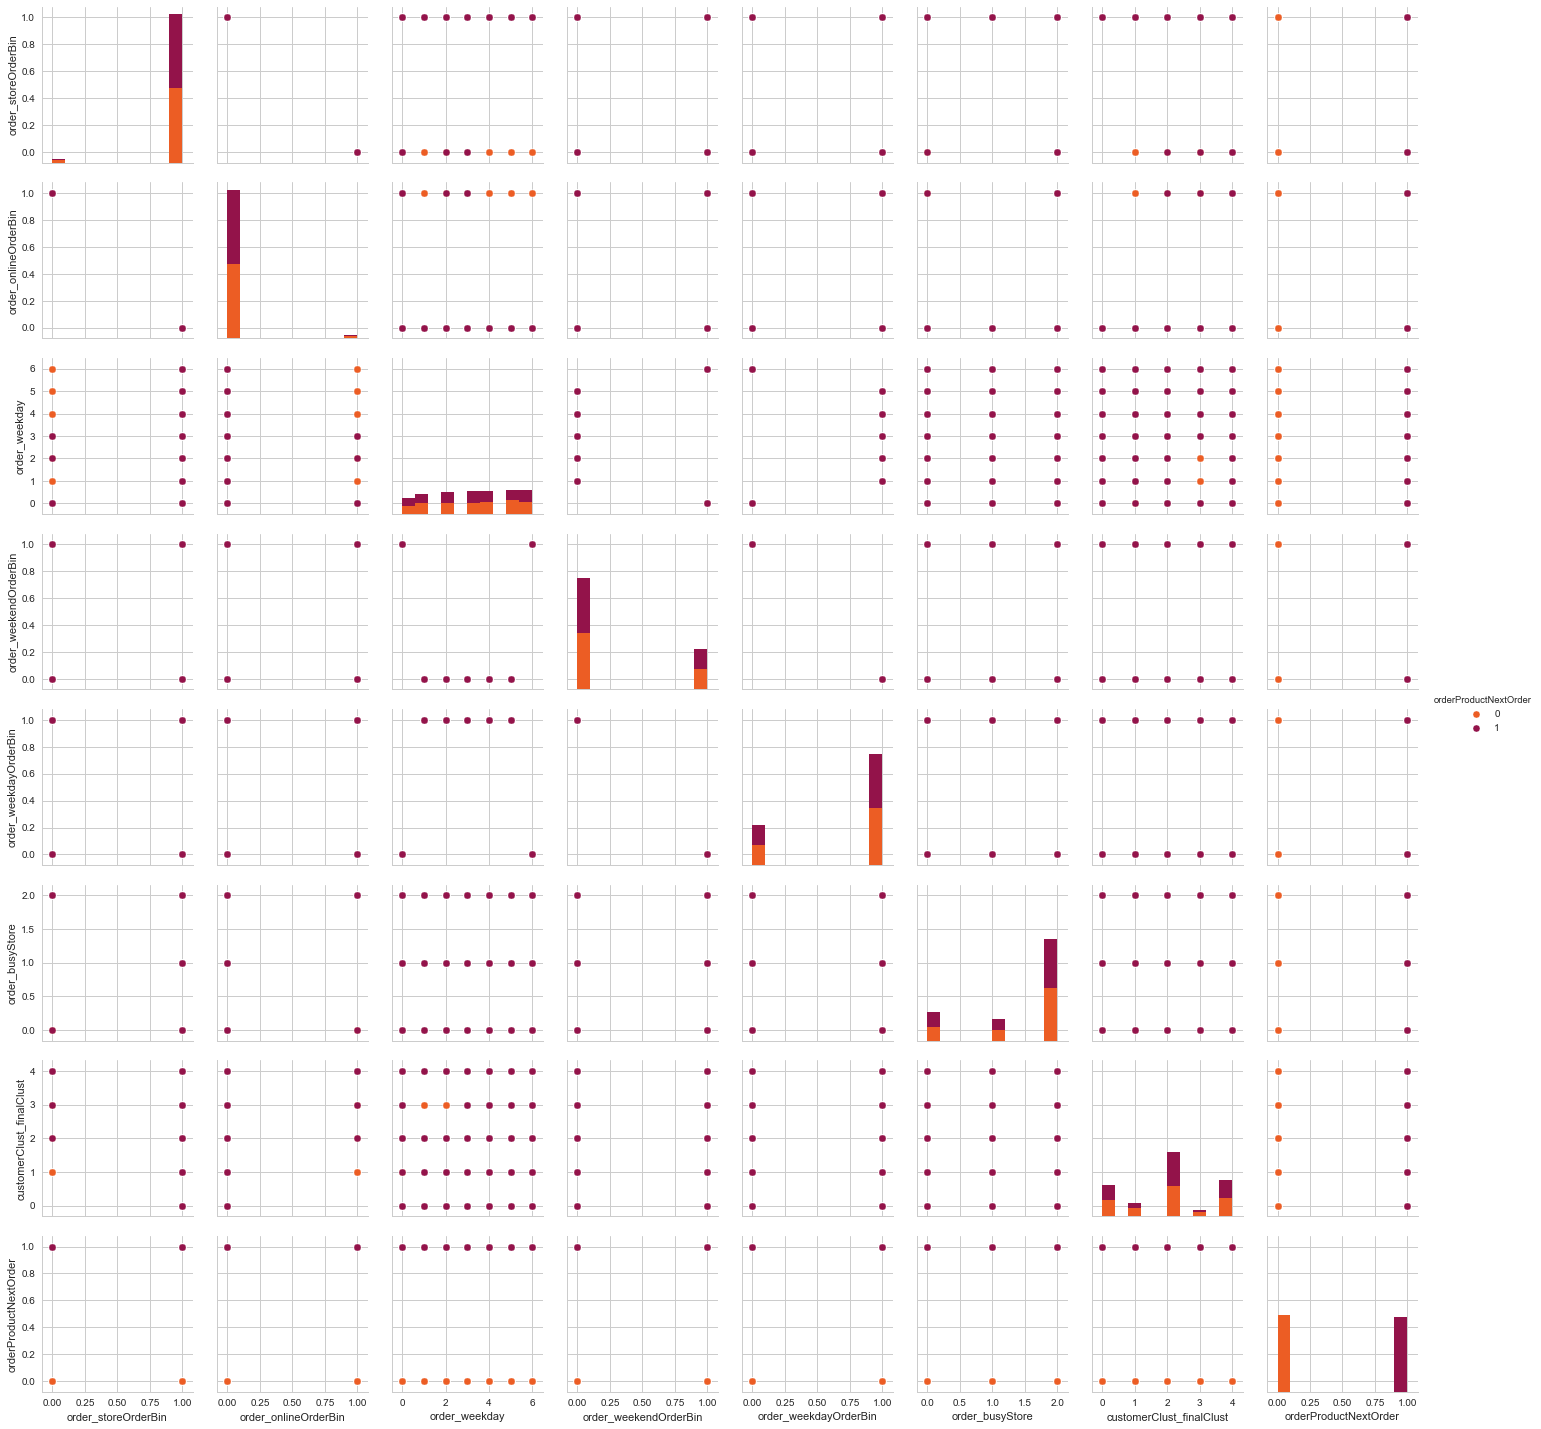

In [311]:
sns.pairplot(
    pd.concat(
        [trainData.loc[:,categoricalFeatures],
         trainData.loc[:,target]],axis = 1), hue=target)

### 6.6.2 Chi-Squared Test for Independence

Seeing as we are working with categorical features and we would like to know whether knowing the level at each variable can help up predict the response variable, we will conduct Chi-squared tests on these categorical features with respect to the response variable using a significance level of 0.05 in order to decide whether or not we will keep the variable or drop the variable. Our null hypothesis (H0) for each of the variables we run this test on is that the two respective variables are independent. Our Alternative hypothesis (HA) is that they are not independent.

In [312]:
from scipy.stats import chi2_contingency

In [313]:
relevantCategoricalFeatures = []
for column in categoricalFeatures:
    results = chi2_contingency([
    trainData.loc[:,[column,'orderProductNextOrder']].pivot_table(
        index=column, columns='orderProductNextOrder',aggfunc=len)[0].values,
    trainData.loc[:,[column,'orderProductNextOrder']].pivot_table(
        index=column, columns='orderProductNextOrder',aggfunc=len)[1].values
])
    print('*'*100)
    print(column)
    print('Chi-Squared Stat: {}'.format(results[0]))
    print('p-Value: {}'.format(results[1]))
    print('Degrees Of Freedom: {}'.format(results[2]))
    if results[1]<5e-2:
        relevantCategoricalFeatures.append(column)

****************************************************************************************************
order_storeOrderBin
Chi-Squared Stat: 9.310453480122836
p-Value: 0.0022785007962116957
Degrees Of Freedom: 1
****************************************************************************************************
order_onlineOrderBin
Chi-Squared Stat: 9.310453480122835
p-Value: 0.002278500796211696
Degrees Of Freedom: 1
****************************************************************************************************
order_weekday
Chi-Squared Stat: 5.286232384428975
p-Value: 0.5076601324218237
Degrees Of Freedom: 6
****************************************************************************************************
order_weekendOrderBin
Chi-Squared Stat: 0.08510778048268984
p-Value: 0.7704912513257386
Degrees Of Freedom: 1
****************************************************************************************************
order_weekdayOrderBin
Chi-Squared Stat: 0.08510778048268985
p-Value

Here we can see that the remaining relevant columns based on our Chi-Squared test are:

['order_storeOrderBin', 'order_onlineOrderBin', 'customerClust_finalClust']

However, we know that the storeOrderBin and the OnlineOrderBin both capture the same information because if an order is not made in-store it is made online. There are no other sales channels within our data so one of these columns are redundant. We will keep th onlineOrderBin as this Chi-Squared Stat and p-values score only slightly better, leaving us with;

['order_onlineOrderBin', 'customerClust_finalClust']

In [314]:
finalCategoricalFeatures = ['order_onlineOrderBin', 'customerClust_finalClust']

### 6.6.3 Dummies

We currently have 2 categorical features left, however for the 'customerClust_finalClust' feature we need to be able to use this witihn linear models. This feature is populated with numbers representing the clusters in which people belong. We will create dummy variables in order to be able to use this data.

In [315]:
catData = pd.concat(
    [trainData.order_onlineOrderBin,
     pd.get_dummies(trainData.customerClust_finalClust, prefix='cluster')],axis = 1)

In [316]:
catData.head()

,order_onlineOrderBin,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,0,1,0,0,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,1,0,0,0,0
4,1,0,0,0,1,0


### 6.6.4 Summary of categorical feature treatment
(We will keep a summary at the end of each section so that we can quickly review what we need to do to both the test and validation sets. We will do this by building a data-cleaning function)

- Only keep ['order_onlineOrderBin', 'customerClust_finalClust']
- Produce dummy variables of 'customerClust_finalClust'

## 6.7 Numeric Features

### 6.7.1 Intro

Now we can work on processing our numeric features. These will be handled differently to our categorical features. 

### 6.7.2 Correlation

We can see that there are a lot of features to go through, however we know that some of these will provide the same amount of information. For these, we will drop one of the columns as this would be made redundant by keeping the other. To start, we will produce a correlation table and create a list of features that we will remove due to perfect correlation (+ve and -ve). We can filter by the absolute value for ease of reading.

In [835]:
numCorrelations = trainData.loc[:,numericFeatures].corr()
numCorrelations.head()

,order_totalItemsPurchased,order_numberOfDifferentProducts,order_averageItemsPerProduct,order_uniquenessOfOrder,order_proportionOfTotalProductPurchase,order_proportionOfProductsInOrderWithinOneOrderAgo,order_proportionOfProductsInOrderWithin2OrdersAgo,order_numberOfProductsRefundsInOrder,order_proportionOfOrderSizeOfStoreTotal,order_proportionOfOrderDifferenceOfStoreTotal,order_storeOrderPerCustomer,order_storeProportionOfTotalProductsSold,customer_totalShoppingOrders,order_shoppingOrder,customer_totalStoreOrders,customer_totalWebOrders,customer_storeOrdersProportion,customer_webOrdersProportion,customer_totalNumberOfItemsPurchased,customer_averageNumberOfItemsPurchasedPerOrder,customer_proportionOfTotalItemsPurchasedOne,customer_totalWeekendOrders,customer_totalWeekdayOrders,customer_WeekendOrdersProportion,customer_WeekdayOrdersProportion,customer_totalItemsPurchasedWeekend,customer_totalItemsPurchasedWeekday,customer_itemsPurchasedWeekendProportion,customer_itemsPurchasedWeekdayProportion,customer_proportionOfProductRangePurchased,customer_ordersPerUniqueProduct,customer_numberOfDifferentStoresPurchased,customer_averageOrdersPerStore,customer_proportionOfOrdersWithRepeatedProductsPurchased,customer_averageUniquenessOfOrder,customer_averageBusyStore,customer_averageProportionOfOrderSizeOfStoreTotal,customer_averageProportionOfOrderDifferenceOfStoreTotal,store_totalNumberOfOrders,store_averageTotalNumberOfOrdersPerDay,store_totalNumberOfOrdersWithRefund,store_totalCustomers,store_totalNumberOfItemsSold,store_totalProductRange,store_ordersPerCustomer,store_proportionOfTotalProductsSold,store_proportionOfOrdersWithRefunds,store_weekendOrders,store_weekdayOrders,store_averageWeekendOrdersPerDay,store_averageWeekdayOrdersPerDay,previousProductOrders
order_totalItemsPurchased,1.000000,0.969371,0.112831,0.001955,-0.080106,0.015316,0.008576,0.120540,0.031903,0.052174,0.202979,0.221402,-0.161112,-0.070085,-0.179336,0.179644,-0.231952,0.231039,0.379695,0.631054,-0.177907,-0.114415,-0.158807,0.013354,-0.013354,0.214783,0.330366,0.011000,-0.011000,0.332364,-0.327334,-0.146150,-0.040446,0.240753,-0.113698,0.085478,-0.022982,-0.000629,0.201195,0.201195,0.127231,0.166293,0.216252,0.221402,0.202979,0.221402,0.082098,0.191247,0.203870,0.191247,0.203870,-0.023215
order_numberOfDifferentProducts,0.969371,1.000000,-0.020721,0.016725,-0.071699,-0.004434,-0.002701,0.138682,0.035784,0.058153,0.195866,0.222520,-0.157029,-0.070768,-0.175727,0.182668,-0.236417,0.233402,0.355616,0.604744,-0.069931,-0.108035,-0.156272,0.021829,-0.021829,0.219162,0.298397,0.017823,-0.017823,0.349971,-0.345203,-0.126531,-0.052313,0.242119,-0.098665,0.091637,-0.014161,0.010711,0.199210,0.199210,0.115546,0.164879,0.215588,0.222520,0.195866,0.222520,0.079643,0.185969,0.203099,0.185969,0.203099,-0.049788
order_averageItemsPerProduct,0.112831,-0.020721,1.000000,0.002021,0.022841,0.010217,-0.010811,-0.003788,0.001666,-0.007089,0.012842,-0.017336,-0.030488,-0.014019,-0.029646,-0.004186,0.004411,-0.003730,0.007144,0.023215,-0.242788,-0.023858,-0.029107,-0.012530,0.012530,-0.009494,0.014502,-0.021004,0.021004,-0.047878,0.064647,-0.024246,-0.008668,-0.049240,-0.019853,-0.049334,-0.002446,-0.004575,-0.022525,-0.022525,-0.008219,-0.034201,-0.016786,-0.017336,0.012842,-0.017336,0.001179,-0.020674,-0.023093,-0.020674,-0.023093,-0.006936
order_uniquenessOfOrder,0.001955,0.016725,0.002021,1.000000,0.850574,-0.331464,-0.372424,-0.029882,0.068835,0.019935,0.024507,0.093926,-0.284370,-0.193997,-0.276883,-0.023986,0.030209,-0.026759,-0.277148,-0.058294,0.099087,-0.212191,-0.275913,0.037520,-0.037520,-0.151917,-0.244115,0.013430,-0.013430,-0.143039,-0.201084,0.046161,-0.268764,-0.379641,0.585882,-0.023817,0.029262,-0.011557,0.069426,0.069426,0.070647,0.035307,0.088358,0.093926,0.024507,0.093926,0.060694,0.072021,0.068146,0.072021,0.068146,-0.136068
order_proportionOfTotalProductPurchase,-0.080106,-0.071699,0.022841,0.850574,1.000000,-0.355664,-0.370455,-0.026894,0.061072,0.007004,-0.088773,0

In [318]:
checked = []
perfectCorrelation= []
for i in numericFeatures:
    print(numCorrelations.loc[i,[j for j in numericFeatures if j!=i and j not in checked]][abs(numCorrelations.loc[i,[j for j in numericFeatures if j!=i and j not in checked]].values)>0.99])
    if numCorrelations.loc[i,[j for j in numericFeatures if j!=i and j not in checked]][abs(numCorrelations.loc[i,[j for j in numericFeatures if j!=i and j not in checked]].values)>0.99].index.tolist():
        perfectCorrelation.append(i)
    print('*'*100)
    checked.append(i)

    

Series([], Name: order_totalItemsPurchased, dtype: float64)
****************************************************************************************************
Series([], Name: order_numberOfDifferentProducts, dtype: float64)
****************************************************************************************************
Series([], Name: order_averageItemsPerProduct, dtype: float64)
****************************************************************************************************
Series([], Name: order_uniquenessOfOrder, dtype: float64)
****************************************************************************************************
Series([], Name: order_proportionOfTotalProductPurchase, dtype: float64)
****************************************************************************************************
Series([], Name: order_proportionOfProductsInOrderWithinOneOrderAgo, dtype: float64)
******************************************************************************************

In [319]:
perfectCorrelation

['order_storeOrderPerCustomer',
 'order_storeProportionOfTotalProductsSold',
 'customer_totalShoppingOrders',
 'customer_WeekendOrdersProportion',
 'customer_itemsPurchasedWeekendProportion',
 'store_totalNumberOfOrders',
 'store_averageTotalNumberOfOrdersPerDay',
 'store_totalNumberOfItemsSold',
 'store_totalProductRange',
 'store_weekendOrders',
 'store_weekdayOrders']

In [320]:
filteredPerfectCorrData = trainData.loc[:,[i for i in trainData if i not in perfectCorrelation+iDs+targetCol]]

In [321]:
filteredPerfectCorrData.head()

,order_shoppingOrder,order_totalItemsPurchased,order_numberOfDifferentProducts,order_averageItemsPerProduct,order_storeOrderBin,order_onlineOrderBin,order_weekday,order_weekendOrderBin,order_weekdayOrderBin,order_uniquenessOfOrder,order_proportionOfTotalProductPurchase,order_proportionOfProductsInOrderWithinOneOrderAgo,order_proportionOfProductsInOrderWithin2OrdersAgo,order_numberOfProductsRefundsInOrder,order_proportionOfOrderSizeOfStoreTotal,order_proportionOfOrderDifferenceOfStoreTotal,order_busyStore,customer_totalStoreOrders,customer_totalWebOrders,customer_storeOrdersProportion,customer_webOrdersProportion,customer_totalNumberOfItemsPurchased,customer_averageNumberOfItemsPurchasedPerOrder,customer_proportionOfTotalItemsPurchasedOne,customer_totalWeekendOrders,customer_totalWeekdayOrders,customer_WeekdayOrdersProportion,customer_totalItemsPurchasedWeekend,customer_totalItemsPurchasedWeekday,customer_itemsPurchasedWeekdayProportion,customer_proportionOfProductRangePurchased,customer_ordersPerUniqueProduct,customer_numberOfDifferentStoresPurchased,customer_averageOrdersPerStore,customer_proportionOfOrdersWithRepeatedProductsPurchased,customer_averageUniquenessOfOrder,customer_averageBusyStore,customer_averageProportionOfOrderSizeOfStoreTotal,customer_averageProportionOfOrderDifferenceOfStoreTotal,customerClust_finalClust,store_totalNumberOfOrdersWithRefund,store_totalCustomers,store_ordersPerCustomer,store_proportionOfTotalProductsSold,store_proportionOfOrdersWithRefunds,store_averageWeekendOrdersPerDay,store_averageWeekdayOrdersPerDay,previousProductOrders
0,4,5,4,1.250000,1,0,5,0,1,0.250000,0.333333,0.25,0.500000,0,0.000232,0.000655,2,5.0,0.0,1.0,0.0,19.0,3.800000,0.631579,0,5,1.000000,0,19,1.000000,0.000461,0.625000,1,5.000000,1.000000,0.230000,2.000000,0.000176,0.000491,0,10,164,8.817073,0.351796,0.006916,186.5,214.6,0.0
1,3,16,15,1.066667,1,0,5,0,1,0.266667,0.238806,0.20,0.266667,0,0.000410,0.001503,2,8.0,0.0,1.0,0.0,148.0,18.500000,0.709459,3,5,0.625000,60,88,0.594595,0.003858,0.119403,1,8.000000,1.000000,0.391612,2.000000,0.000474,0.001516,2,11,358,7.335196,0.574505,0.004189,348.5,385.8,0.0
2,9,5,5,1.000000,1,0,6,1,0,0.600000,0.714286,0.00,0.200000,0,0.001223,0.002384,1,14.0,0.0,1.0,0.0,214.0,15.285714,0.948598,7,7,0.500000,125,89,0.415888,0.009155,0.088050,3,4.666667,1.000000,0.513650,1.142857,0.004751,0.010691,2,2,69,4.710145,0.120739,0.006154,44.0,47.4,1.0
3,11,2,2,1.000000,1,0,5,0,1,0.500000,0.222222,0.00,0.000000,0,0.000093,0.000327,2,14.0,0.0,1.0,0.0,58.0,4.142857,0.603448,1,13,0.928571,2,56,0.965517,0.001497,0.538462,4,3.500000,0.928571,0.396088,1.500000,0.003602,0.005452,0,10,164,8.817073,0.351796,0.006916,186.5,214.6,0.0
4,2,62,50,1.240000,0,1,6,1,0,0.440000,0.553571,0.38,0.000000,0,0.002482,0.007377,2,0.0,3.0,0.0,1.0,176.0,58.666667,0.659091,3,0,0.000000,176,0,0.000000,0.005355,0.032258,1,3.000000,1.000000,0.399558,2.000000,0.002348,0.006885,3,26,220,7.968182,0.390258,0.014832,263.0,245.4,0.0


In [836]:
filteredPerfectCorrDataCorr = filteredPerfectCorrData.corr()
filteredPerfectCorrDataCorr.head()

,order_shoppingOrder,order_totalItemsPurchased,order_numberOfDifferentProducts,order_averageItemsPerProduct,order_storeOrderBin,order_onlineOrderBin,order_weekday,order_weekendOrderBin,order_weekdayOrderBin,order_uniquenessOfOrder,order_proportionOfTotalProductPurchase,order_proportionOfProductsInOrderWithinOneOrderAgo,order_proportionOfProductsInOrderWithin2OrdersAgo,order_numberOfProductsRefundsInOrder,order_proportionOfOrderSizeOfStoreTotal,order_proportionOfOrderDifferenceOfStoreTotal,order_busyStore,customer_totalStoreOrders,customer_totalWebOrders,customer_storeOrdersProportion,customer_webOrdersProportion,customer_totalNumberOfItemsPurchased,customer_averageNumberOfItemsPurchasedPerOrder,customer_proportionOfTotalItemsPurchasedOne,customer_totalWeekendOrders,customer_totalWeekdayOrders,customer_WeekdayOrdersProportion,customer_totalItemsPurchasedWeekend,customer_totalItemsPurchasedWeekday,customer_itemsPurchasedWeekdayProportion,customer_proportionOfProductRangePurchased,customer_ordersPerUniqueProduct,customer_numberOfDifferentStoresPurchased,customer_averageOrdersPerStore,customer_proportionOfOrdersWithRepeatedProductsPurchased,customer_averageUniquenessOfOrder,customer_averageBusyStore,customer_averageProportionOfOrderSizeOfStoreTotal,customer_averageProportionOfOrderDifferenceOfStoreTotal,customerClust_finalClust,store_totalNumberOfOrdersWithRefund,store_totalCustomers,store_ordersPerCustomer,store_proportionOfTotalProductsSold,store_proportionOfOrdersWithRefunds,store_averageWeekendOrdersPerDay,store_averageWeekdayOrdersPerDay,previousProductOrders
order_shoppingOrder,1.000000,-0.070085,-0.070768,-0.014019,0.066153,-0.066153,-0.076231,0.054642,-0.054642,-0.193997,-0.270417,-0.009677,0.047395,-0.022355,-0.022892,-0.003853,-0.046478,0.667820,0.003750,0.091838,-0.076738,0.362101,-0.169725,0.092732,0.521384,0.641249,0.041033,0.175221,0.333184,0.031379,0.346914,0.092906,0.096988,0.411612,0.206556,-0.333569,-0.046456,-0.024349,-0.003708,0.075139,-0.045571,-0.059505,0.060636,-0.031590,-0.034357,-0.045213,-0.041961,0.575156
order_totalItemsPurchased,-0.070085,1.000000,0.969371,0.112831,-0.306847,0.306847,-0.040459,0.040132,-0.040132,0.001955,-0.080106,0.015316,0.008576,0.120540,0.031903,0.052174,0.144642,-0.179336,0.179644,-0.231952,0.231039,0.379695,0.631054,-0.177907,-0.114415,-0.158807,-0.013354,0.214783,0.330366,-0.011000,0.332364,-0.327334,-0.146150,-0.040446,0.240753,-0.113698,0.085478,-0.022982,-0.000629,0.248669,0.127231,0.166293,0.202979,0.221402,0.082098,0.191247,0.203870,-0.023215
order_numberOfDifferentProducts,-0.070768,0.969371,1.000000,-0.020721,-0.313645,0.313645,-0.029768,0.038534,-0.038534,0.016725,-0.071699,-0.004434,-0.002701,0.138682,0.035784,0.058153,0.149383,-0.175727,0.182668,-0.236417,0.233402,0.355616,0.604744,-0.069931,-0.108035,-0.156272,-0.021829,0.219162,0.298397,-0.017823,0.349971,-0.345203,-0.126531,-0.052313,0.242119,-0.098665,0.091637,-0.014161,0.010711,0.264244,0.115546,0.164879,0.195866,0.222520,0.079643,0.185969,0.203099,-0.049788
order_averageItemsPerProduct,-0.014019,0.112831,-0.020721,1.000000,0.001870,-0.001870,-0.024615,-0.007262,0.007262,0.002021,0.022841,0.010217,-0.010811,-0.003788,0.001666,-0.007089,-0.054831,-0.029646,-0.004186,0.004411,-0.003730,0.007144,0.023215,-0.242788,-0.023858,-0.029107,0.012530,-0.009494,0.014502,0.021004,-0.047878,0.064647,-0.024246,-0.008668,-0.049240,-0.019853,-0.049334,-0.002446,-0.004575,-0.037308,-0.008219,-0.034201,0.012842,-0.017336,0.001179,-0.020674,-0.023093,-0.006936
order_storeOrderBin,0.066153,-0.306847,-0.313645,0.001870,1.000000,-1.000000,0.016139,-0.011607,0.011607,0.047715,0.040400,-0.088334,-0.046763,-0.360631,0.011387,0.010532,-0.059497,0.171840,-0.615795,0.790665,-0.789304,-0.078504,-0.301992,0.041548,0.100874,0.096156,-0.015421,-0.021458,-0.082354,-0.006953,-0.042866,0.102157,0.078766,0.045330,-0.055001,0.071673,-0.020975,0.003316,0.008594,-0.054090,-0.080150,-0.063876,-0.065972,-0.080921,-0.254597,-0.078311,-0.076718,0.057369


In [323]:
checked2 = []
highCorrelation= []
for i in filteredPerfectCorrDataCorr.index.tolist():
    print(filteredPerfectCorrDataCorr.loc[i,[j for j in filteredPerfectCorrDataCorr.index.tolist() if j!=i and j not in checked2]][abs(filteredPerfectCorrDataCorr.loc[i,[j for j in filteredPerfectCorrDataCorr.index.tolist() if j!=i and j not in checked2]].values)>0.85])
    if filteredPerfectCorrDataCorr.loc[i,[j for j in filteredPerfectCorrDataCorr.index.tolist() if j!=i and j not in checked2]][abs(filteredPerfectCorrDataCorr.loc[i,[j for j in filteredPerfectCorrDataCorr.index.tolist() if j!=i and j not in checked2]].values)>0.85].index.tolist():
        highCorrelation.append(i)
    print('*'*100)
    checked2.append(i)

Series([], Name: order_shoppingOrder, dtype: float64)
****************************************************************************************************
order_numberOfDifferentProducts    0.969371
Name: order_totalItemsPurchased, dtype: float64
****************************************************************************************************
Series([], Name: order_numberOfDifferentProducts, dtype: float64)
****************************************************************************************************
Series([], Name: order_averageItemsPerProduct, dtype: float64)
****************************************************************************************************
order_onlineOrderBin   -1.0
Name: order_storeOrderBin, dtype: float64
****************************************************************************************************
Series([], Name: order_onlineOrderBin, dtype: float64)
***********************************************************************************************

In [324]:
highCorrelation

['order_totalItemsPurchased',
 'order_storeOrderBin',
 'order_weekendOrderBin',
 'order_uniquenessOfOrder',
 'order_proportionOfOrderSizeOfStoreTotal',
 'order_busyStore',
 'customer_totalStoreOrders',
 'customer_storeOrdersProportion',
 'customer_totalNumberOfItemsPurchased',
 'customer_WeekdayOrdersProportion',
 'customer_averageProportionOfOrderSizeOfStoreTotal',
 'store_totalCustomers',
 'store_proportionOfTotalProductsSold',
 'store_averageWeekendOrdersPerDay']

In [325]:
fullNumData = trainData.loc[:,[i for i in numericFeatures if i not in perfectCorrelation+iDs+targetCol]]

In [326]:
reducedNumData = fullNumData.loc[:,[i for i in numericFeatures if i not in perfectCorrelation+highCorrelation+iDs+targetCol]]

Here we can separate the dataset to ensure that the data is suitable for which ever model we will be using. For models that are able to select features like trees or models with L1 and L2 regularization.

### 6.7.3 Standard Quality checks

There are no features with 0 variance and there are no missing values in any of the features for each order.

In [327]:
fullNumData.var()[fullNumData.var()==0]

Series([], dtype: float64)

In [328]:
fullNumData[fullNumData.isnull().any(axis =1)]

,order_totalItemsPurchased,order_numberOfDifferentProducts,order_averageItemsPerProduct,order_uniquenessOfOrder,order_proportionOfTotalProductPurchase,order_proportionOfProductsInOrderWithinOneOrderAgo,order_proportionOfProductsInOrderWithin2OrdersAgo,order_numberOfProductsRefundsInOrder,order_proportionOfOrderSizeOfStoreTotal,order_proportionOfOrderDifferenceOfStoreTotal,order_shoppingOrder,customer_totalStoreOrders,customer_totalWebOrders,customer_storeOrdersProportion,customer_webOrdersProportion,customer_totalNumberOfItemsPurchased,customer_averageNumberOfItemsPurchasedPerOrder,customer_proportionOfTotalItemsPurchasedOne,customer_totalWeekendOrders,customer_totalWeekdayOrders,customer_WeekdayOrdersProportion,customer_totalItemsPurchasedWeekend,customer_totalItemsPurchasedWeekday,customer_itemsPurchasedWeekdayProportion,customer_proportionOfProductRangePurchased,customer_ordersPerUniqueProduct,customer_numberOfDifferentStoresPurchased,customer_averageOrdersPerStore,customer_proportionOfOrdersWithRepeatedProductsPurchased,customer_averageUniquenessOfOrder,customer_averageBusyStore,customer_averageProportionOfOrderSizeOfStoreTotal,customer_averageProportionOfOrderDifferenceOfStoreTotal,store_totalNumberOfOrdersWithRefund,store_totalCustomers,store_ordersPerCustomer,store_proportionOfTotalProductsSold,store_proportionOfOrdersWithRefunds,store_averageWeekendOrdersPerDay,store_averageWeekdayOrdersPerDay,previousProductOrders


### 6.7.4 Transformations - KDE Plots, BoxCox & Centering and Scaling

Here we can assess our variables and analyse their distributions. We can transform the variables so that they are more normally distributed (a very common assumption made in modelling solutions). We will also store the alpha values derived from the boxcox function should we wish to transform the variables back to view the effects in a more understandable scale.

In [329]:
from scipy.stats import boxcox
from sklearn.preprocessing import scale

****************************************************************************************************
order_totalItemsPurchased


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/cbook.py:2641: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


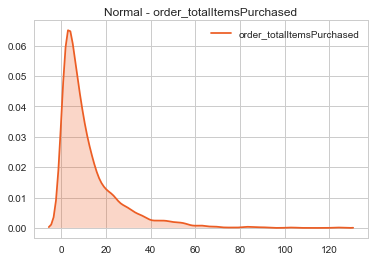

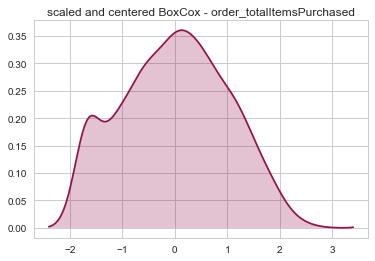

****************************************************************************************************
order_numberOfDifferentProducts


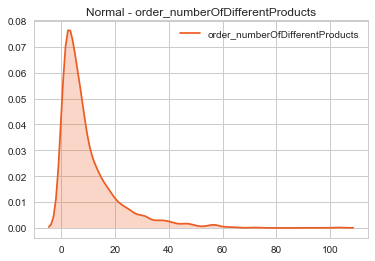

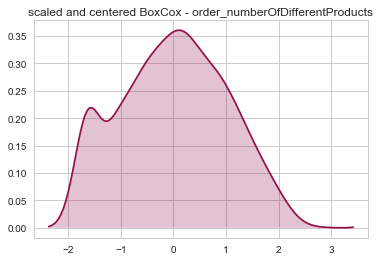

****************************************************************************************************
order_averageItemsPerProduct


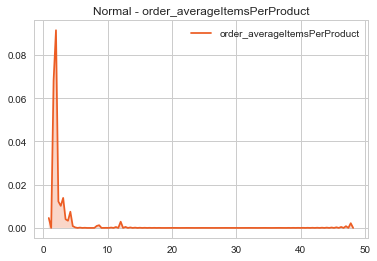

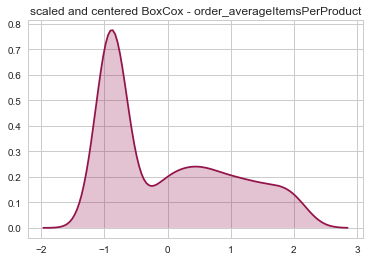

****************************************************************************************************
order_uniquenessOfOrder


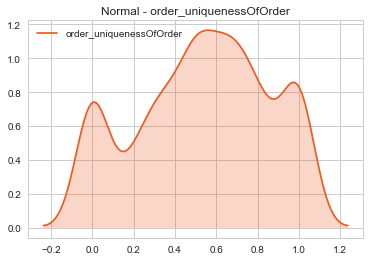

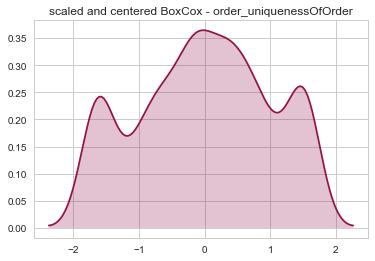

****************************************************************************************************
order_proportionOfTotalProductPurchase


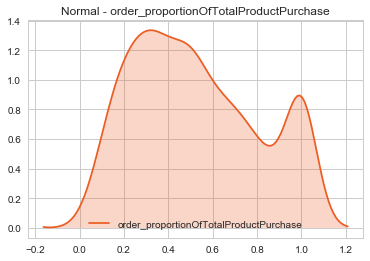

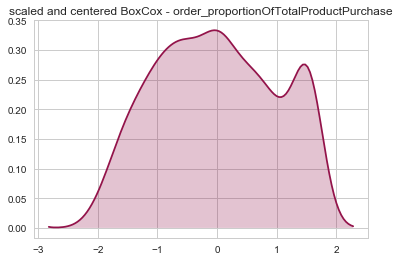

****************************************************************************************************
order_proportionOfProductsInOrderWithinOneOrderAgo


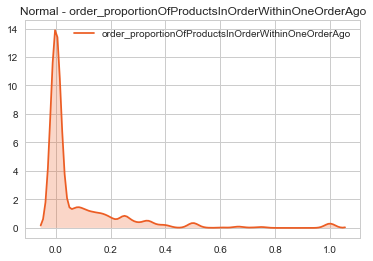

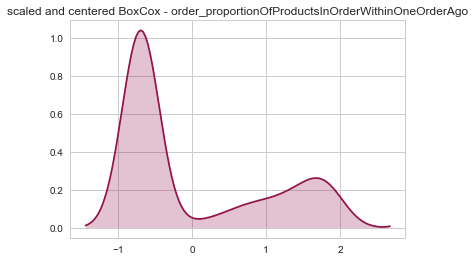

****************************************************************************************************
order_proportionOfProductsInOrderWithin2OrdersAgo


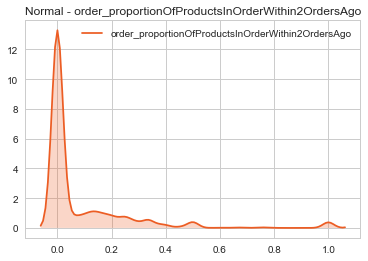

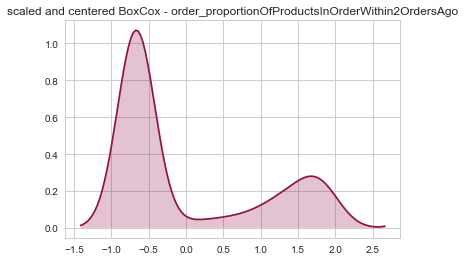

****************************************************************************************************
order_numberOfProductsRefundsInOrder


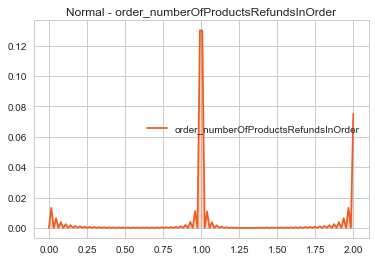

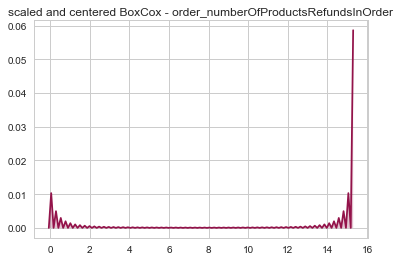

****************************************************************************************************
order_proportionOfOrderSizeOfStoreTotal


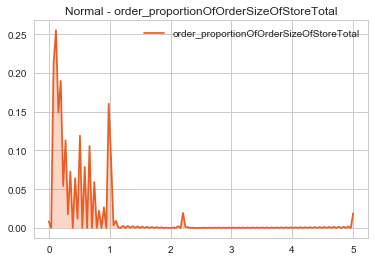

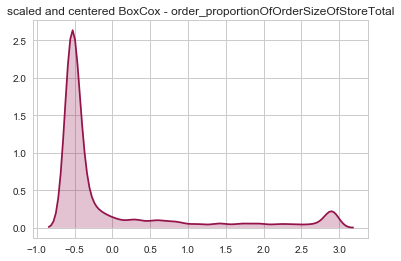

****************************************************************************************************
order_proportionOfOrderDifferenceOfStoreTotal


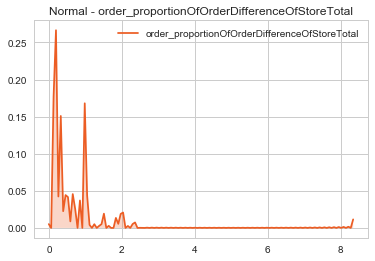

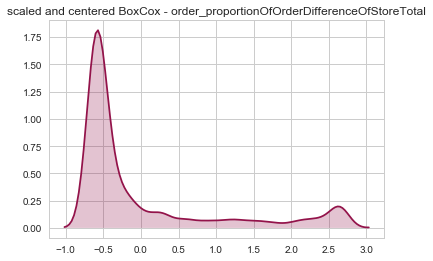

****************************************************************************************************
order_shoppingOrder


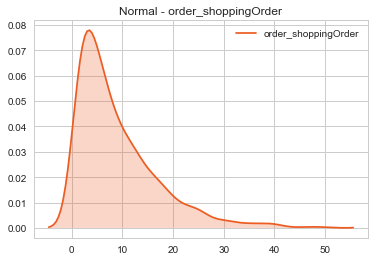

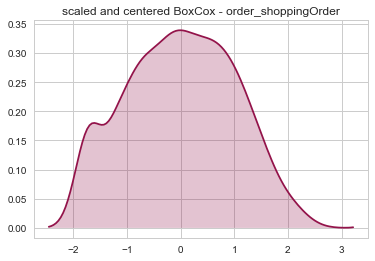

****************************************************************************************************
customer_totalStoreOrders


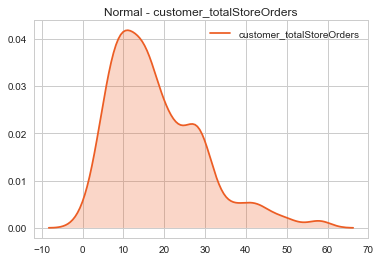

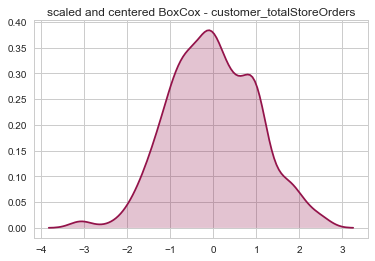

****************************************************************************************************
customer_totalWebOrders


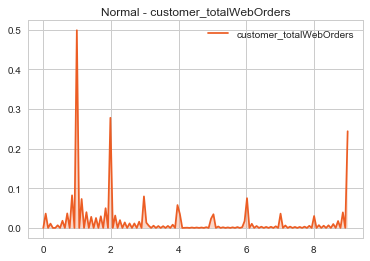

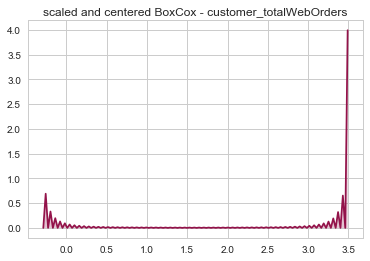

****************************************************************************************************
customer_storeOrdersProportion


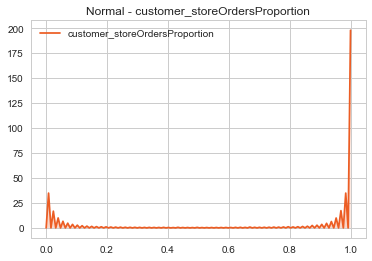

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


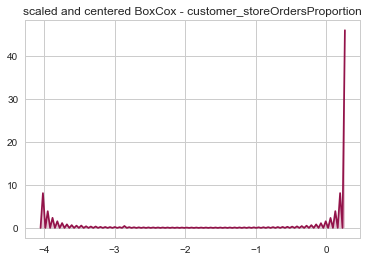

****************************************************************************************************
customer_webOrdersProportion


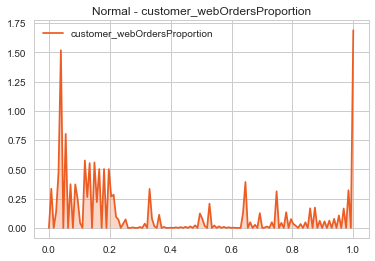

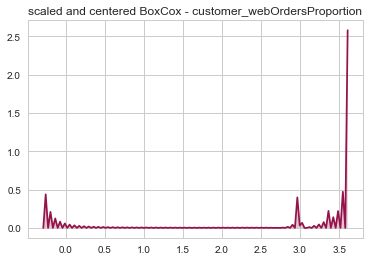

****************************************************************************************************
customer_totalNumberOfItemsPurchased


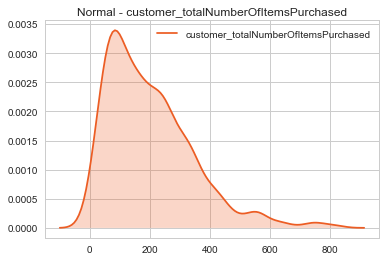

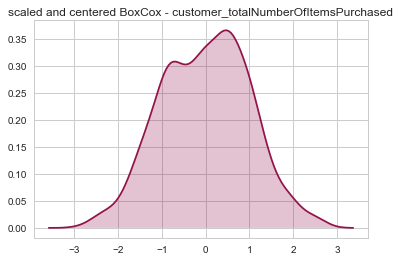

****************************************************************************************************
customer_averageNumberOfItemsPurchasedPerOrder


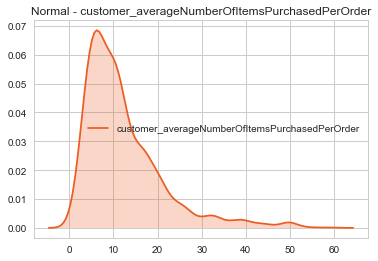

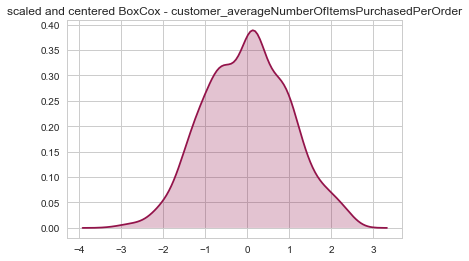

****************************************************************************************************
customer_proportionOfTotalItemsPurchasedOne


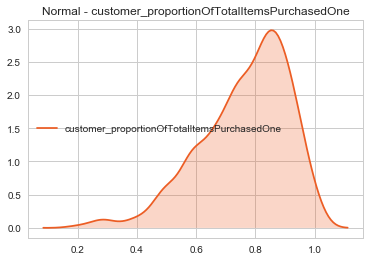

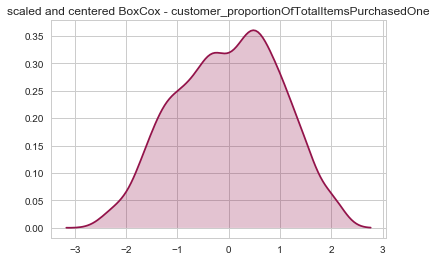

****************************************************************************************************
customer_totalWeekendOrders


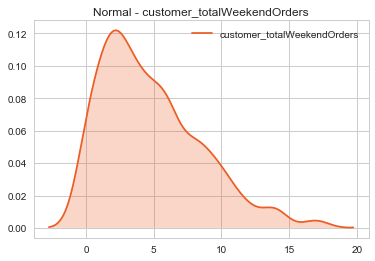

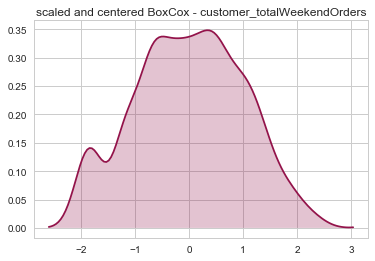

****************************************************************************************************
customer_totalWeekdayOrders


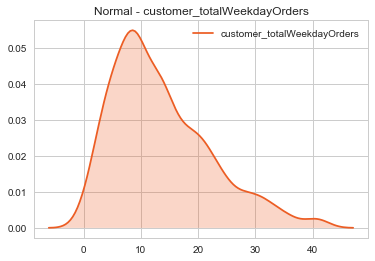

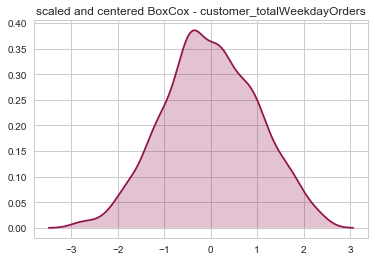

****************************************************************************************************
customer_WeekdayOrdersProportion


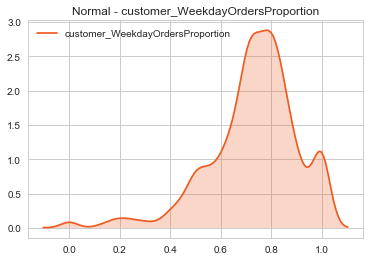

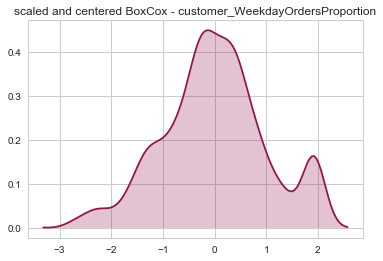

****************************************************************************************************
customer_totalItemsPurchasedWeekend


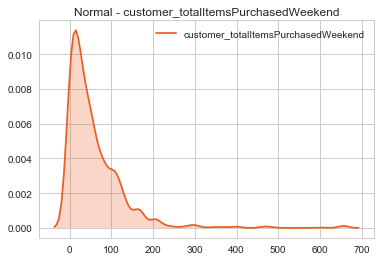

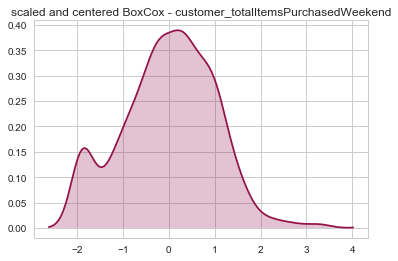

****************************************************************************************************
customer_totalItemsPurchasedWeekday


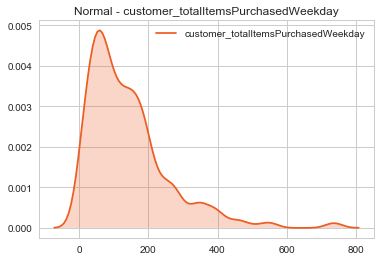

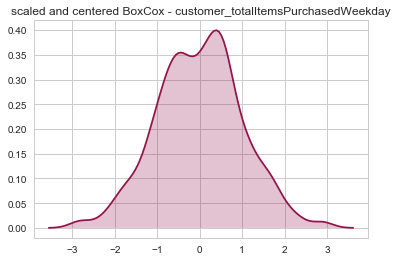

****************************************************************************************************
customer_itemsPurchasedWeekdayProportion


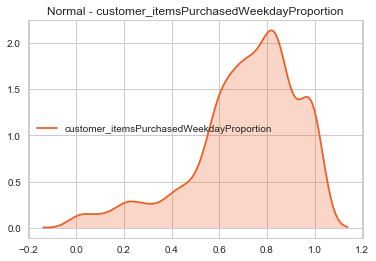

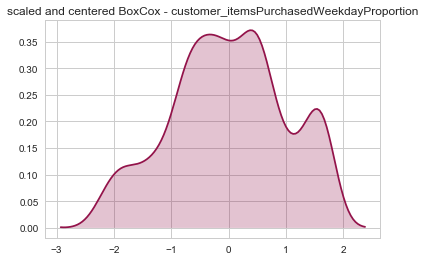

****************************************************************************************************
customer_proportionOfProductRangePurchased


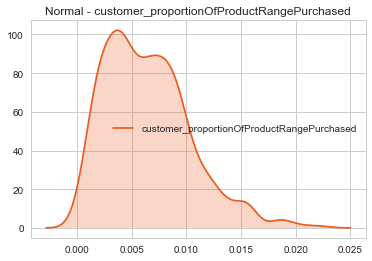

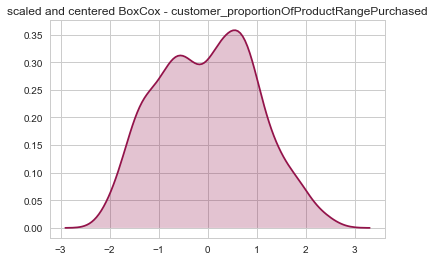

****************************************************************************************************
customer_ordersPerUniqueProduct


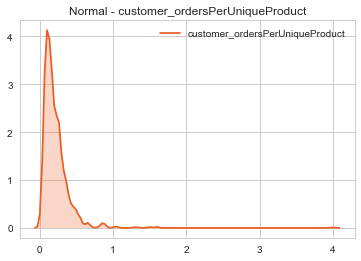

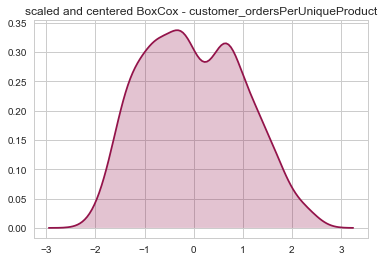

****************************************************************************************************
customer_numberOfDifferentStoresPurchased


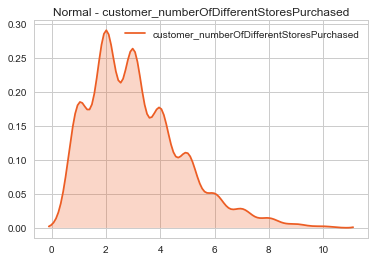

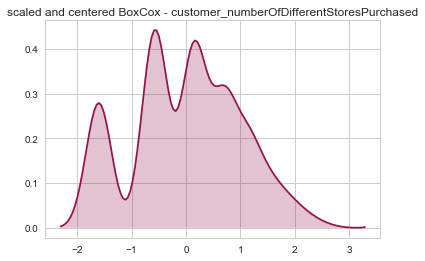

****************************************************************************************************
customer_averageOrdersPerStore


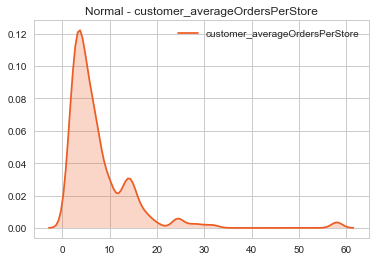

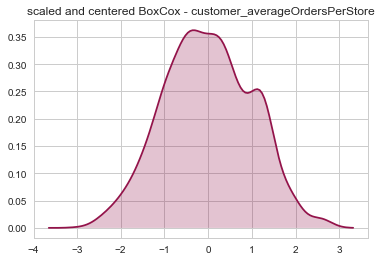

****************************************************************************************************
customer_proportionOfOrdersWithRepeatedProductsPurchased


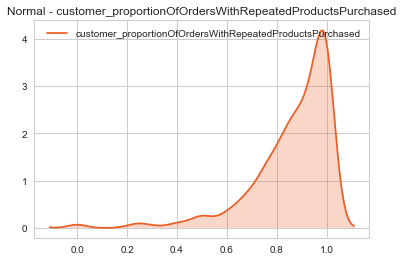

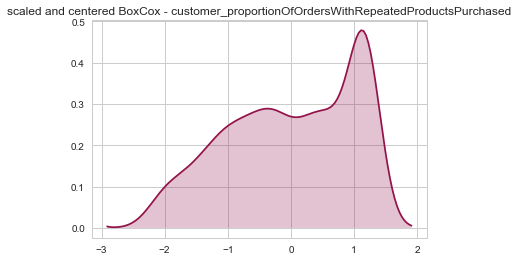

****************************************************************************************************
customer_averageUniquenessOfOrder


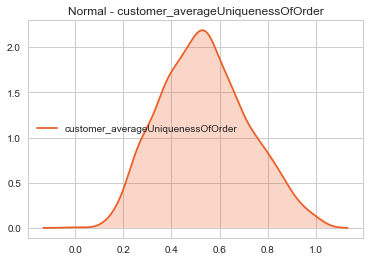

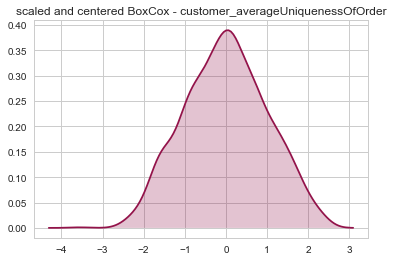

****************************************************************************************************
customer_averageBusyStore


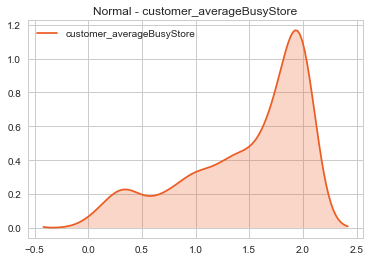

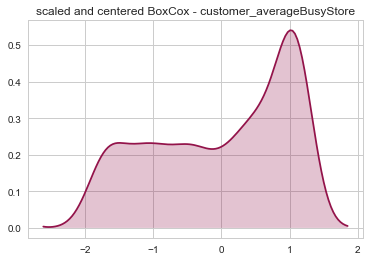

****************************************************************************************************
customer_averageProportionOfOrderSizeOfStoreTotal


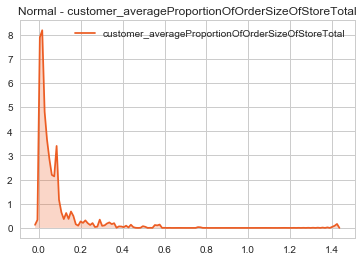

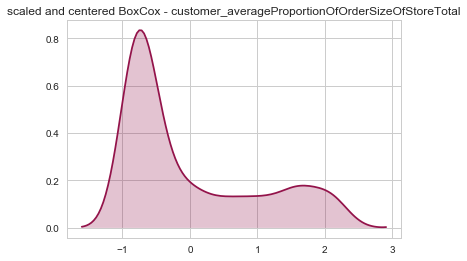

****************************************************************************************************
customer_averageProportionOfOrderDifferenceOfStoreTotal


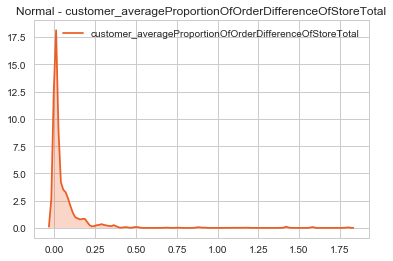

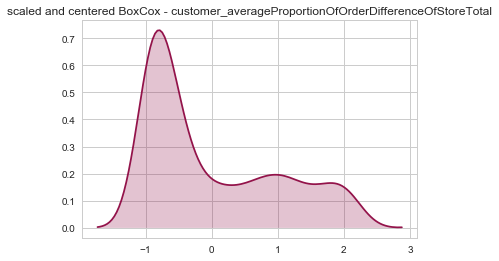

****************************************************************************************************
store_totalNumberOfOrdersWithRefund


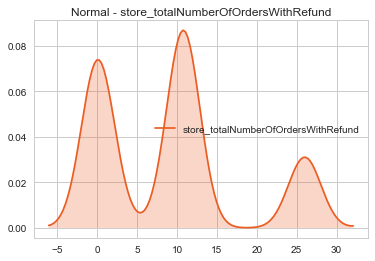

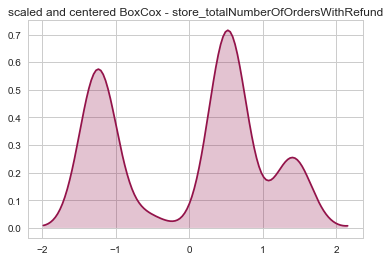

****************************************************************************************************
store_totalCustomers


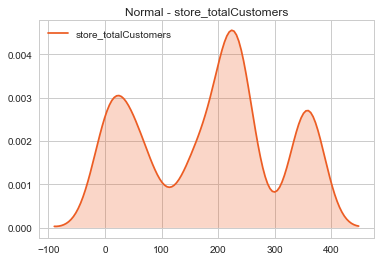

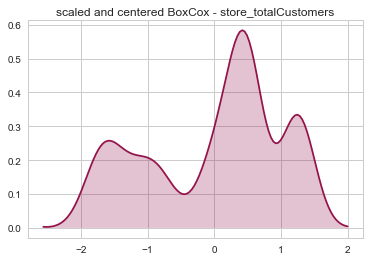

****************************************************************************************************
store_ordersPerCustomer


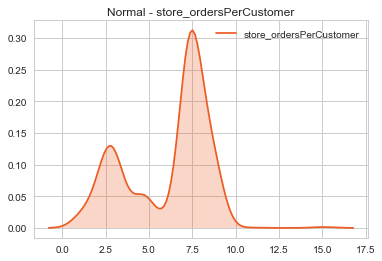

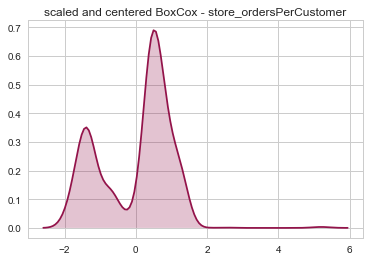

****************************************************************************************************
store_proportionOfTotalProductsSold


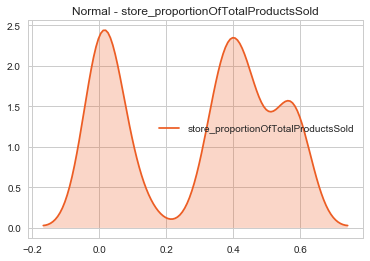

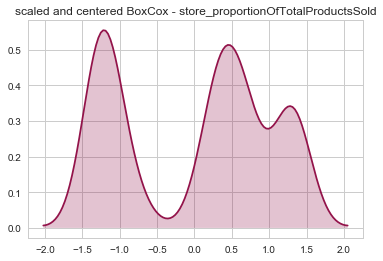

****************************************************************************************************
store_proportionOfOrdersWithRefunds


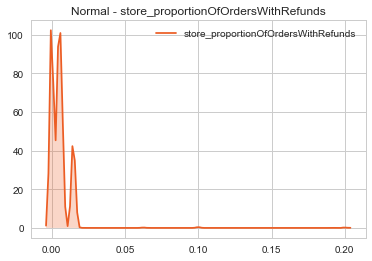

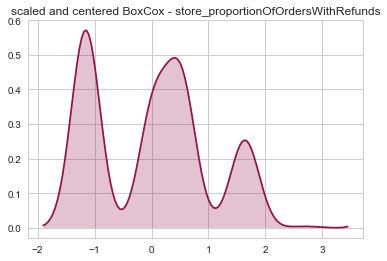

****************************************************************************************************
store_averageWeekendOrdersPerDay


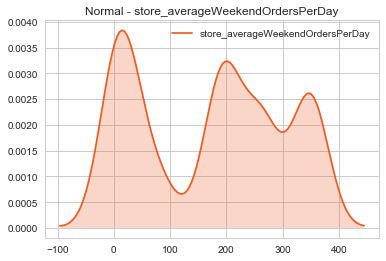

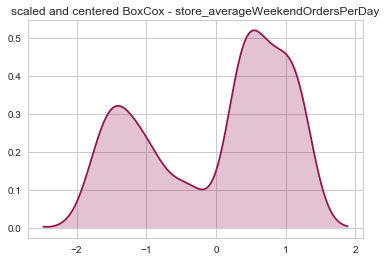

****************************************************************************************************
store_averageWeekdayOrdersPerDay


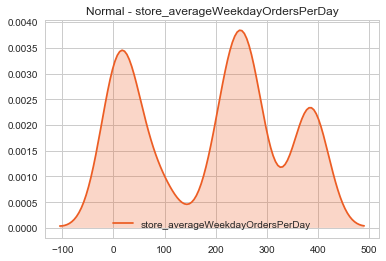

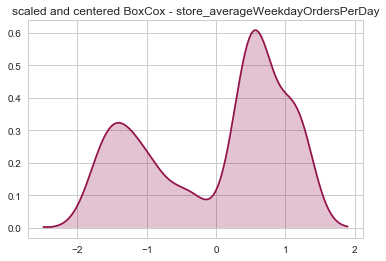

****************************************************************************************************
previousProductOrders


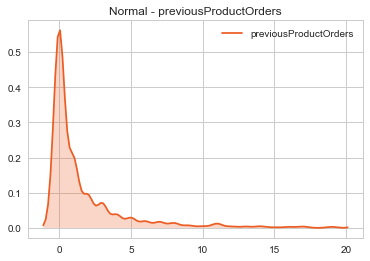

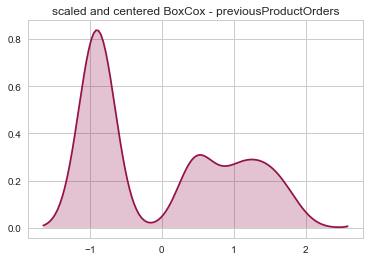

In [330]:
for col in fullNumData.columns:
    print('*'*100)
    print(col)
    try:
        sns.kdeplot(fullNumData[col], shade=True, c=shopColors[0])
        plt.title('Normal - {}'.format(col))
        plt.show()
    except:
        continue
    try:
        sns.kdeplot(scale(boxcox(fullNumData[col]+1)[0]), shade=True, c=shopColors[1])
        plt.title('scaled and centered BoxCox - {}'.format(col))
        plt.show()
    except:
        continue

In [352]:
boxcoxLambdas = dict()
fullTransformedData = fullNumData.copy()
for col in fullNumData.columns:
    boxcoxLambdas[col] = boxcox(fullNumData[col]+1)[1]
    fullTransformedData[col] = scale(boxcox(fullNumData[col]+1)[0])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [355]:
reducedTransformedData = fullTransformedData.loc[:,[i for i in numericFeatures if i not in perfectCorrelation+highCorrelation+iDs+targetCol]]

### 6.7.5 Summary of numeric feature treatment

- Filter out perfect Correlation features:

    ['order_storeOrderPerCustomer',
 'order_storeProportionOfTotalProductsSold',
 'customer_totalShoppingOrders',
 'customer_WeekendOrdersProportion',
 'customer_itemsPurchasedWeekendProportion',
 'store_totalNumberOfOrders',
 'store_averageTotalNumberOfOrdersPerDay',
 'store_totalNumberOfItemsSold',
 'store_totalProductRange',
 'store_weekendOrders',
 'store_weekdayOrders']
 
 
- Perform BoxCox Transformation on Variables and then scale on all variables available
 
 
- Parition data to full data and reduced data based on high Correlation Features::

    ['order_totalItemsPurchased',
 'order_storeOrderBin',
 'order_weekendOrderBin',
 'order_proportionOfOrderSizeOfStoreTotal',
 'order_busyStore',
 'customer_totalStoreOrders',
 'customer_totalWebOrders',
 'customer_storeOrdersProportion',
 'customer_totalNumberOfItemsPurchased',
 'customer_WeekdayOrdersProportion',
 'customer_averageProportionOfOrderSizeOfStoreTotal',
 'store_totalCustomers',
 'store_proportionOfTotalProductsSold',
 'store_averageWeekendOrdersPerDay']

## 6.8 Combine Data & Fuctional Cleaning

Here we will combine the data and check that everything is as we would expect, checking if there are any highly correlating features within the reduce data set, whether we need to balace the classes and if any dimension reduction techniques are required.

### 6.8.1 Combine

Here we have combined the categorical and numerical features based on a reduced and full data set.

In [356]:
print(fullTransformedData.shape)
fullTransformedData.head(3)

(1410, 41)


,order_totalItemsPurchased,order_numberOfDifferentProducts,order_averageItemsPerProduct,order_uniquenessOfOrder,order_proportionOfTotalProductPurchase,order_proportionOfProductsInOrderWithinOneOrderAgo,order_proportionOfProductsInOrderWithin2OrdersAgo,order_numberOfProductsRefundsInOrder,order_proportionOfOrderSizeOfStoreTotal,order_proportionOfOrderDifferenceOfStoreTotal,order_shoppingOrder,customer_totalStoreOrders,customer_totalWebOrders,customer_storeOrdersProportion,customer_webOrdersProportion,customer_totalNumberOfItemsPurchased,customer_averageNumberOfItemsPurchasedPerOrder,customer_proportionOfTotalItemsPurchasedOne,customer_totalWeekendOrders,customer_totalWeekdayOrders,customer_WeekdayOrdersProportion,customer_totalItemsPurchasedWeekend,customer_totalItemsPurchasedWeekday,customer_itemsPurchasedWeekdayProportion,customer_proportionOfProductRangePurchased,customer_ordersPerUniqueProduct,customer_numberOfDifferentStoresPurchased,customer_averageOrdersPerStore,customer_proportionOfOrdersWithRepeatedProductsPurchased,customer_averageUniquenessOfOrder,customer_averageBusyStore,customer_averageProportionOfOrderSizeOfStoreTotal,customer_averageProportionOfOrderDifferenceOfStoreTotal,store_totalNumberOfOrdersWithRefund,store_totalCustomers,store_ordersPerCustomer,store_proportionOfTotalProductsSold,store_proportionOfOrdersWithRefunds,store_averageWeekendOrdersPerDay,store_averageWeekdayOrdersPerDay,previousProductOrders
0,-0.361125,-0.442924,0.913026,-0.920271,-0.637254,1.686851,1.884302,-0.065372,-0.551574,-0.615599,-0.518795,-1.459616,-0.286563,0.261014,-0.285938,-2.048472,-1.439465,-0.992954,-1.850531,-1.080596,1.922226,-1.883323,-1.528449,1.647290,-1.970806,1.950917,-1.603041,-0.141900,1.166228,-1.844635,1.10582,-0.850186,-0.971912,0.460808,0.005264,1.234728,0.236223,0.593052,0.351221,0.375077,-0.899596
1,0.762199,0.882261,-0.210831,-0.871013,-1.060926,1.554668,1.708053,-0.065372,-0.532242,-0.558577,-0.808150,-0.948747,-0.286563,0.261014,-0.285938,-0.147702,0.953103,-0.534455,-0.317168,-1.080596,-0.746338,0.435456,-0.262611,-0.728347,-0.633287,-0.613840,-1.603041,0.506372,1.166228,-0.801895,1.10582,-0.830905,-0.928258,0.543583,1.254739,0.463573,1.305057,0.027699,1.143713,1.151330,-0.899596
2,-0.361125,-0.223035,-0.886749,0.163608,0.741786,-0.694314,1.544552,-0.065372,-0.445174,-0.500475,0.377683,-0.203904,-0.286563,0.261014,-0.285938,0.339752,0.669366,1.456444,0.736052,-0.707012,-1.337022,1.140294,-0.250766,-1.367609,0.823897,-1.053477,0.149162,-0.240765,1.166228,-0.083653,-0.83611,-0.567451,-0.565500,-0.583190,-0.813248,-0.706871,-0.784256,0.448536,-0.775219,-0.825611,0.474997


In [357]:
print(catData.shape)
catData.head(3)

(1410, 6)


,order_onlineOrderBin,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,0,1,0,0,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0


In [358]:
iD = trainData.orderID
Xfull = pd.concat([fullTransformedData,catData], axis=1).astype(np.float32)
Xred = pd.concat([reducedTransformedData,catData], axis=1).astype(np.float32)
Y = trainData.orderProductNextOrder

### 6.8.2 Process X Data

Here we can build a function to clean the data using the steps we executed above. We are able to use the stored lambdas for boxcox transformations on the training set, so we can use the same transformations on the test and valid set.

In [758]:
def processXdata(Xdata,boxcoxLambdas):
    
    iDs = [i for i in finalData.columns if 'ID' in i]
    cats = ['order_onlineOrderBin', 'customerClust_finalClust']
    catRemove = ['order_storeOrderBin','order_weekday','order_weekendOrderBin','order_weekdayOrderBin','order_busyStore']
    numRemove = ['order_storeOrderPerCustomer', 'order_storeProportionOfTotalProductsSold', 'customer_totalShoppingOrders', 'customer_WeekendOrdersProportion', 'customer_itemsPurchasedWeekendProportion', 'store_totalNumberOfOrders', 'store_averageTotalNumberOfOrdersPerDay', 'store_totalNumberOfItemsSold', 'store_totalProductRange', 'store_weekendOrders', 'store_weekdayOrders']
    highCorrCol = ['order_totalItemsPurchased', 'order_storeOrderBin', 'order_weekendOrderBin', 'order_proportionOfOrderSizeOfStoreTotal', 'order_busyStore', 'customer_totalStoreOrders', 'customer_totalWebOrders', 'customer_storeOrdersProportion', 'customer_totalNumberOfItemsPurchased', 'customer_WeekdayOrdersProportion', 'customer_averageProportionOfOrderSizeOfStoreTotal', 'store_totalCustomers', 'store_proportionOfTotalProductsSold', 'store_averageWeekendOrdersPerDay']
    targetCol = ['orderProductNextOrder']
    
    Xcat = pd.concat(
        [Xdata.order_onlineOrderBin,
         pd.get_dummies(Xdata.customerClust_finalClust, prefix='cluster')],axis = 1)
    Xdata = Xdata.loc[:, [i for i in Xdata.columns if i not in iDs+cats+catRemove+numRemove+targetCol]]
    
    Xffull = pd.DataFrame(index=Xdata.index)
    for col in Xdata.columns:
        Xffull[col] = scale(((Xdata.loc[:,col]+1)**boxcoxLambdas[col] - 1) / boxcoxLambdas[col])
    
    Xffull = pd.concat([Xffull,Xcat],axis=1)
    
    Xred = Xffull.loc[:,[i for i in Xffull.columns if i not in highCorrCol]]
    
    return Xffull, Xred

In [730]:
Xf,Xr = processXdata(trainData,boxcoxLambdas)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [733]:
Xf.shape

(1410, 47)

In [734]:
Xfull.shape

(1410, 47)

## 6.9 Modelling

Now we can begin the modelling process. We will continue to only use the training data as we cross validate using 5-Folds. This will help balance our scores. Here we will be able to avoid overfitting.

### 6.9.1 Baselines

Here we will use a LogisticRegession model as a baseline for linear models and a decision tree as a baseline for tree-based models. These types of models will use different data, the full set for decision tree based models and the reduced set for linear models.

In [345]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_curve,classification_report

In [346]:
def re_iterate(model, X_train, Y_train, folds, iterations):
    
    """
    This function averages n_number of models' metrics and returns values relating to performance
    model = model
    X_train = Features / predictor values
    Y_train = Target Variable
    folds = Number of folds in cross validated scores
    iterations = number of differnt models to train
    
    RETURNS
    Returns a series of metrics and useful plotting data
    """
    
    avg_c_val_scores = []
    avg_probs = pd.DataFrame()
    
    splitPoint = int(X_train.shape[0]*0.75)
    
    X_train, Y_train = shuffle(np.array(X_train), np.array(Y_train))
    Xtr = X_train[:-splitPoint]
    Ytr = Y_train[:-splitPoint]
    Xte = X_train[-splitPoint:]
    Yte = Y_train[-splitPoint:]
    
    for i in range(iterations):
        r_state = np.random.randint(1,1000000)
        kf = KFold(n_splits=folds, shuffle=True, random_state=r_state)
        model.fit(Xtr, Ytr)
        c_val_score = cross_val_score(model, X_train, Y_train,cv=kf)
        avg_c_val_scores.append(c_val_score.mean())
        probs_ = model.predict_proba(Xte)[:,1]
        avg_probs[i] = probs_
        
    avg_probs['total_avg'] = avg_probs.apply(lambda x: np.mean(x), axis=1)
    
    fpr_, tpr_, thresholds_ = roc_curve(Yte, avg_probs.total_avg)
    
    c_report = classification_report(Yte,round(avg_probs.total_avg))
    
    return np.mean(avg_c_val_scores), avg_c_val_scores, fpr_, tpr_, thresholds_, c_report

In [347]:
lr = LogisticRegression(class_weight='balanced')
dt = DecisionTreeClassifier(class_weight='balanced')

lrAvBaseScore, lrAvBaseScores, lrFPR, lrTPR, lrThresholds, lrCreport = re_iterate(lr,Xred,Y,5,10)
dtAvBaseScore, dtAvBaseScores, dtFPR, dtTPR, dtThresholds, dtCreport = re_iterate(dt,Xred,Y,5,10)

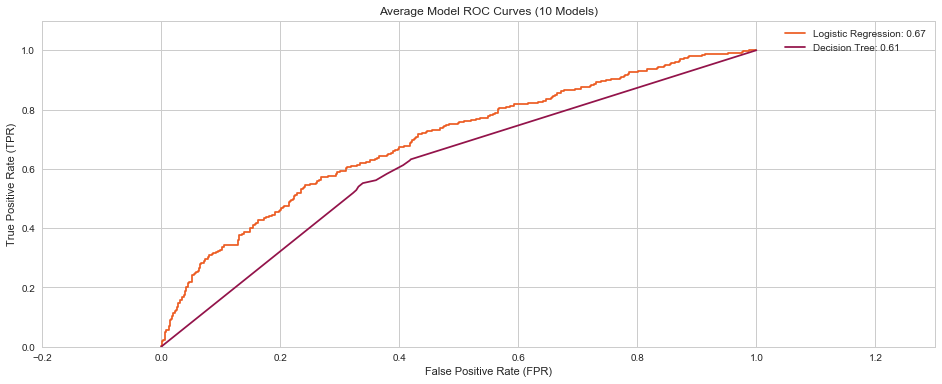

In [348]:
plt.figure(figsize=(16,6)); plt.xlim([-0.2, 1.3]); plt.ylim([0, 1.1])
plt.title('Average Model ROC Curves (10 Models)'); plt.xlabel('False Positive Rate (FPR)'); plt.ylabel('True Positive Rate (TPR)')
plt.plot(lrFPR, lrTPR, label='Logistic Regression: {}'.format(round(lrAvBaseScore,2)), c=shopColors[0])
plt.plot(dtFPR, dtTPR, label='Decision Tree: {}'.format(round(dtAvBaseScore,2)), c=shopColors[1])
plt.legend()
plt.show()

In [349]:
print('Logistic Regression Results')
print(lrCreport)
print('Decision Tree')
print(dtCreport)

Logistic Regression Results
             precision    recall  f1-score   support

          0       0.64      0.67      0.65       532
          1       0.65      0.62      0.63       525

avg / total       0.64      0.64      0.64      1057

Decision Tree
             precision    recall  f1-score   support

          0       0.61      0.64      0.62       546
          1       0.59      0.56      0.58       511

avg / total       0.60      0.60      0.60      1057



### 6.9.2 Other Model Defaults

Here we can try a number of different models to see how they perform in general in comparison to each other. We will use the same function we wrote above which iterates over several models and cross validates to generate as accurate a representation of the model's performance.

In [378]:
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier

In [379]:
from sklearn.ensemble import BaggingClassifier

In [395]:
ridge = RidgeClassifier()
svc = SVC(max_iter = 10000)
# ------------------------
kn = KNeighborsClassifier(n_neighbors=5)
mlp = MLPClassifier(hidden_layer_sizes=(100, ),max_iter = 10000)

ada = AdaBoostClassifier(n_estimators=500)
et = ExtraTreesClassifier(n_estimators=500)
gb = GradientBoostingClassifier(n_estimators=500)
rf = RandomForestClassifier(n_estimators=500)

In [396]:
print('Building K-Nearest Neighbors')
knAvBaseScore, knAvBaseScores, knFPR, knTPR, knThresholds, knCreport = re_iterate(kn,Xfull,Y,5,10)
print('Building Neural Networks')
mlpAvBaseScore, mlpAvBaseScores, mlpFPR, mlpTPR, mlpThresholds, mlpCreport = re_iterate(mlp,Xred,Y,5,10)


print('Building ADA-Boosted Trees')
adaAvBaseScore, adaAvBaseScores, adaFPR, adaTPR, adaThresholds, adaCreport = re_iterate(ada,Xfull,Y,5,10)
print('Building Extra-Trees')
etAvBaseScore, etAvBaseScores, etFPR, etTPR, etThresholds, etCreport = re_iterate(et,Xfull,Y,5,10)
print('Building Gradient Boosted Trees')
gbAvBaseScore, gbAvBaseScores, gbFPR, gbTPR, gbThresholds, gbCreport = re_iterate(gb,Xfull,Y,5,10)
print('Building K-Nearest Neighbors')
rfAvBaseScore, rfAvBaseScores, rfFPR, rfTPR, rfThresholds, rfCreport = re_iterate(rf,Xfull,Y,5,10)

Building K-Nearest Neighbors
Building Neural Networks
Building ADA-Boosted Trees
Building Extra-Trees
Building Gradient Boosted Trees
Building K-Nearest Neighbors


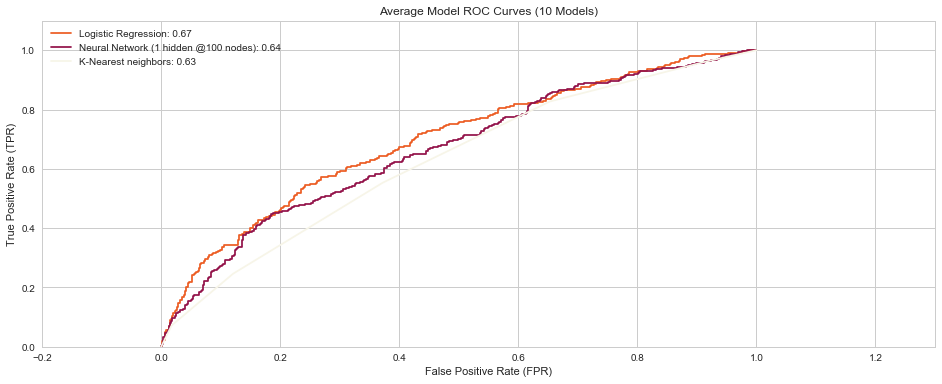

In [402]:
plt.figure(figsize=(16,6)); plt.xlim([-0.2, 1.3]); plt.ylim([0, 1.1])
plt.title('Average Model ROC Curves (10 Models)'); plt.xlabel('False Positive Rate (FPR)'); plt.ylabel('True Positive Rate (TPR)')
plt.plot(lrFPR, lrTPR, label='Logistic Regression: {}'.format(round(lrAvBaseScore,2)), c=shopColors[0])
plt.plot(mlpFPR, mlpTPR, label='Neural Network (1 hidden @100 nodes): {}'.format(round(mlpAvBaseScore,2)), c=shopColors[1])
plt.plot(knFPR, knTPR, label='K-Nearest neighbors: {}'.format(round(knAvBaseScore,2)), c=shopColors[2])

plt.legend()
plt.show()

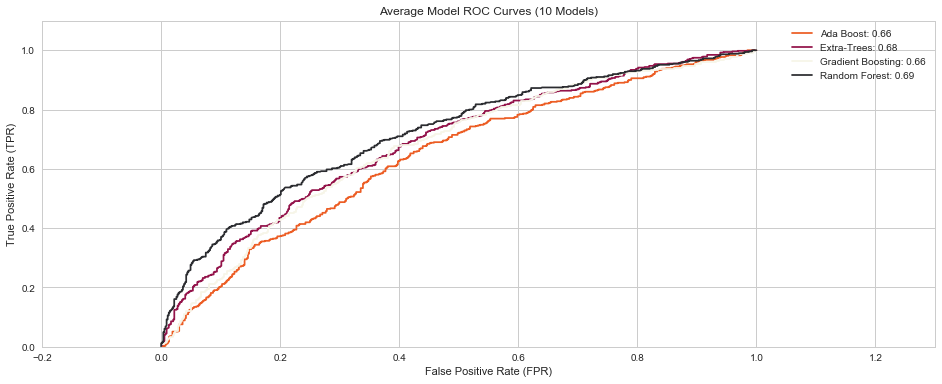

In [398]:
plt.figure(figsize=(16,6)); plt.xlim([-0.2, 1.3]); plt.ylim([0, 1.1])
plt.title('Average Model ROC Curves (10 Models)'); plt.xlabel('False Positive Rate (FPR)'); plt.ylabel('True Positive Rate (TPR)')
plt.plot(adaFPR, adaTPR, label='Ada Boost: {}'.format(round(adaAvBaseScore,2)), c=shopColors[0])
plt.plot(etFPR, etTPR, label='Extra-Trees: {}'.format(round(etAvBaseScore,2)), c=shopColors[1])
plt.plot(gbFPR, gbTPR, label='Gradient Boosting: {}'.format(round(gbAvBaseScore,2)), c=shopColors[2])
plt.plot(rfFPR, rfTPR, label='Random Forest: {}'.format(round(rfAvBaseScore,2)), c=shopColors[3])
plt.legend()
plt.show()

This gives us an Idea as to how well each of the models perform on the cross validated training data. We will look to tune these models to perform at their best by using a cross validated GridSearch. This will be cimputationally expensive, therefore, we will not iterate over 10 models with our function whilst we tune the parameters

### 6.9.3 Cross-Validated Grid Search 

Here we can test out a number of combinations of hyperparameters , until the best combination is found and then that is continue. (Grid search is an exhaustive search process which will take a long time to run)

In [421]:
import time
from sklearn.model_selection import GridSearchCV

In [422]:
lrModel = LogisticRegression()
ridgeModel = RidgeClassifier()
svcModel = SVC()
# ------------------------
cModel = KNeighborsClassifier()
mlpModel = MLPClassifier()

adaModel = AdaBoostClassifier()
etModel = ExtraTreesClassifier()
gbModel = GradientBoostingClassifier()
rfModel = RandomForestClassifier()

In [427]:
t0=time.time()
lr_param_grid = {'C': [1,0.5,0.1,0.05,0.01,0.001,0.0001],
                 'penalty':['l1','l2'],
                 'max_iter':[10000], 
                 'class_weight':[{0:0.5,1:0.5},{0:0.55,1:0.45},{0:0.60,1:0.40},{0:0.40,1:0.60}]}
lr_grid = GridSearchCV(lrModel, lr_param_grid, cv=5)
lr_grid.fit(Xfull,Y)
print(lr_grid.best_params_)
print(lr_grid.best_score_)
t1 = time.time()
print('Time Taken: {}'.format(round(t1-t0,2)))

{'max_iter': 10000, 'C': 0.5, 'class_weight': {0: 0.5, 1: 0.5}, 'penalty': 'l2'}
0.704255319149
Time Taken: 2.65


In [428]:
t0=time.time()
ridge_param_grid = {'alpha': [1,0.5,0.1,0.05,0.01,0.001,0.0001],
                 'max_iter':[10000], 
                 'class_weight':[{0:0.5,1:0.5},{0:0.55,1:0.45},{0:0.60,1:0.40},{0:0.40,1:0.60}]}
ridge_grid = GridSearchCV(ridgeModel, ridge_param_grid, cv=5)
ridge_grid.fit(Xfull,Y)
print(ridge_grid.best_params_)
print(ridge_grid.best_score_)
t1 = time.time()
print('Time Taken: {}'.format(round(t1-t0,2)))

{'alpha': 1, 'class_weight': {0: 0.5, 1: 0.5}, 'max_iter': 10000}
0.701418439716
Time Taken: 0.84


In [430]:
t0=time.time()
svc_param_grid = {'C': [1,0.5,0.1,0.05,0.01,0.001,0.0001],
                  'degree':[3,4,5],
                  'kernel':['linear','poly', 'rbf'],
                  'max_iter':[100000], 
                  'class_weight':[{0:0.5,1:0.5},{0:0.55,1:0.45},{0:0.60,1:0.40},{0:0.40,1:0.60}]}
svc_grid = GridSearchCV(svcModel, svc_param_grid, cv=5)
svc_grid.fit(Xfull,Y)
print(svc_grid.best_params_)
print(svc_grid.best_score_)
t1 = time.time()
print('Time Taken: {}'.format(round(t1-t0,2)))

{'degree': 3, 'max_iter': 100000, 'kernel': 'linear', 'C': 0.5, 'class_weight': {0: 0.55, 1: 0.45}}
0.696453900709
Time Taken: 165.3


In [431]:
t0=time.time()
kn_param_grid = {'n_neighbors': [3,5,10],
                 'weights':['uniform', 'distance'],
                 'algorithm':['ball_tree','kd_tree','brute'],
                 'leaf_size':[10,30,50],
                 'p':[1,2]}
kn_grid = GridSearchCV(knModel, kn_param_grid, cv=5)
kn_grid.fit(Xfull,Y)
print(kn_grid.best_params_)
print(kn_grid.best_score_)
t1 = time.time()
print('Time Taken: {}'.format(round(t1-t0,2)))

{'n_neighbors': 5, 'leaf_size': 10, 'algorithm': 'ball_tree', 'p': 1, 'weights': 'distance'}
0.666666666667
Time Taken: 43.43


In [435]:
t0=time.time()
ada_param_grid = {'n_estimators': [20,50,200,500],
                 'learning_rate':[1,1e-1,1e-2,1e-3,1e-4,1e-5]}
ada_grid = GridSearchCV(adaModel, ada_param_grid, cv=5)
ada_grid.fit(Xfull,Y)
print(ada_grid.best_params_)
print(ada_grid.best_score_)
t1 = time.time()
print('Time Taken: {}'.format(round(t1-t0,2)))

{'n_estimators': 200, 'learning_rate': 0.1}
0.695744680851
Time Taken: 91.27


In [441]:
t0=time.time()
et_param_grid = {'n_estimators': [20,50,200,500],
                 'class_weight':[{0:0.5,1:0.5},{0:0.55,1:0.45},{0:0.60,1:0.40},{0:0.40,1:0.60}]}
et_grid = GridSearchCV(etModel, et_param_grid, cv=5)
et_grid.fit(Xfull,Y)
print(et_grid.best_params_)
print(et_grid.best_score_)
t1 = time.time()
print('Time Taken: {}'.format(round(t1-t0,2)))

{'n_estimators': 200, 'class_weight': {0: 0.55, 1: 0.45}}
0.694326241135
Time Taken: 44.74


In [444]:
t0=time.time()
gb_param_grid = {'loss':['deviance','exponential'],
                 'n_estimators': [20,50,200,500],
                 'max_features':['sqrt','log2','auto'],
                 'learning_rate':[1,1e-1,1e-2,1e-3,1e-4,1e-5]}
gb_grid = GridSearchCV(gbModel, gb_param_grid, cv=5)
gb_grid.fit(Xfull,Y)
print(gb_grid.best_params_)
print(gb_grid.best_score_)
t1 = time.time()
print('Time Taken: {}'.format(round(t1-t0,2)))

{'loss': 'deviance', 'n_estimators': 50, 'learning_rate': 0.1, 'max_features': 'log2'}
0.706382978723
Time Taken: 238.55


In [446]:
t0=time.time()
rf_param_grid = {'n_estimators': [20,50,200,500],
                 'max_features':['sqrt','log2','auto'],
                 'class_weight':[{0:0.5,1:0.5},{0:0.55,1:0.45},{0:0.60,1:0.40},{0:0.40,1:0.60}]}
rf_grid = GridSearchCV(rfModel, rf_param_grid, cv=5)
rf_grid.fit(Xfull,Y)
print(rf_grid.best_params_)
print(rf_grid.best_score_)
t1 = time.time()
print('Time Taken: {}'.format(round(t1-t0,2)))

{'n_estimators': 500, 'max_features': 'log2', 'class_weight': {0: 0.5, 1: 0.5}}
0.697872340426
Time Taken: 172.76


In [449]:
nn1 = MLPClassifier()
t0=time.time()
nn1_param_grid = {'hidden_layer_sizes': [(100,),(25,),(500,)],
                 'activation':['logistic', 'tanh', 'relu'],
                 'solver':['lbfgs','sgd','adam'],
                 'alpha':[1e-2,1e-3,1e-4],
                 'learning_rate':['constant','invscaling','adaptive'],
                 'max_iter':[100000]}
nn1_grid = GridSearchCV(nn1, nn1_param_grid, cv=5)
nn1_grid.fit(Xfull,Y)
print(nn1_grid.best_params_)
print(nn1_grid.best_score_)
t1 = time.time()
print('Time Taken: {}'.format(round(t1-t0,2)))

{'alpha': 0.01, 'learning_rate': 'invscaling', 'activation': 'tanh', 'max_iter': 100000, 'solver': 'adam', 'hidden_layer_sizes': (500,)}
0.710638297872
Time Taken: 5196.38


Using the best performing hyperparameters for each of the models, we will be able to use these to inform our decision as to which model we should use, or even system of models we should use to optimise our solution. If we just use the one model, we can  see that the Neural Network is the best performing model.

### 6.9.4 Ensembling, Stacking and Blending using Genetic Algorithms

We can now try to enhance our model by looking to ensemble the best models together to create better predictions. We will use the predictions of the models as meta-features for a stacking model which will predict on thThe main dataset and the metafeatures. By using a genetic algorithm, we take a less exhausive, more informed approach to selecting the models to stack for a specific staker.

We will run the algorithm with a number of stackers to see how they each perform and the best stacker and model combination will be our final model.

In [684]:
# removal of convergence warnings.
import warnings

In [691]:

bestModels = [
    nn1_grid.best_estimator_,
    rf_grid.best_estimator_,
    gb_grid.best_estimator_,
    et_grid.best_estimator_,
    ada_grid.best_estimator_,
    lr_grid.best_estimator_,
    ridge_grid.best_estimator_,
    svc_grid.best_estimator_
]
stackerModels = [
    LogisticRegression(max_iter=100000),
    RidgeClassifier(max_iter=100000),
    SVC(max_iter=100000),
    RandomForestClassifier(n_estimators=200),
    GradientBoostingClassifier(n_estimators=200)
]

bestStackerCombo = []
kf = KFold(n_splits=5)

In [699]:
# Genetic Algorithm To select best models for stacker models

chromosomeLength = len(bestModels)
poolSize = 10 # out of 256 different combinations
iterations = 10
mutationRate = 0.05

iterationResults = dict()

with warnings.catch_warnings(): # added incase of convergence issues
    warnings.simplefilter("ignore")
    for stacker in stackerModels:
        print('*'*100)
        print('[Stacker: {}] Initiating Genetic Algorithm'.format(stacker.__str__().split("(")[0]))
        iterationResults['{}'.format(stacker.__str__().split("(")[0])]=dict()
        pool = np.random.randint(0,2,(poolSize, chromosomeLength))

        for iteration in range(iterations):

            t0 = time.time()

            scores = list()
    #         print('\t[Iteration:{}] Training Pool of Sub-Models'.format(iteration))
            for chrome in pool:
                chosenModels = [m for i,m in zip(chrome,bestModels) if i == 1]

                Xfinal = Xfull.copy()
                #Blending
                for subModel in chosenModels:

                    Xfinal[subModel.__str__().split("(")[0]] = float(0)

                    for tr_idx, te_idx in kf.split(Xfull):

                        Xsubtrain = Xfull.iloc[tr_idx,:]
                        Ysubtrain = Y.iloc[tr_idx]
                        Xsubtest = Xfull.iloc[te_idx,:]
                        Ysubtest = Y.iloc[te_idx]

                        subModel.fit(Xsubtrain,Ysubtrain)

                        try:
                            preds = subModel.predict_proba(Xsubtest)
                            Xfinal.loc[list(te_idx),subModel.__str__().split("(")[0]] = [i[0] for i in preds]
                        except:
                            preds = subModel.predict(Xsubtest)
                            Xfinal.loc[list(te_idx),subModel.__str__().split("(")[0]] = list(preds)

                cvScore = np.mean(cross_val_score(stacker,Xfinal,Y,cv=kf,scoring='f1'))
                scores.append(cvScore)

            scores, pool = (list(t) for t in zip(*sorted(zip(scores, [list(l) for l in list(pool)]),reverse=True)))    
            iterationResults['{}'.format(stacker.__str__().split("(")[0])][iteration] = (scores[0], pool[0])

            if iteration != iterations+1:
    #             print('\t[Iteration:{}] Mutating Model Selections')
                newPool = []
                newPool.append(pool[0])
                newPool.append(pool[0])
                for c in pool[1:int((len(pool)/2))]:
                    random_split_point = np.random.randint(1,len(c))
                    next_gen1 = np.concatenate((pool[0][:random_split_point], c[random_split_point:]), axis = 0)
                    next_gen2 = np.concatenate((c[:random_split_point], pool[0][random_split_point:]), axis = 0)

                    for num, gene in enumerate(next_gen1):
                        if np.random.random() < mutationRate:
                            next_gen1[num] = 1 if gene==0 else 0

                    for num, gene in enumerate(next_gen1):
                        if np.random.random() < mutationRate:
                            next_gen1[num] = 1 if gene==0 else 0

                    newPool.append(next_gen1)
                    newPool.append(next_gen2)
                pool = newPool
            t1 = time.time()
            print('\t[Iteration:{}] Score: {} | TimeTaken: {} Seconds'.format(iteration+1, scores[0], round(t1-t0,2)))

****************************************************************************************************
[Stacker: LogisticRegression] Initiating Genetic Algorithm
	[Iteration:1] Score: 0.7160886330790035 | TimeTaken: 115.92 Seconds
	[Iteration:2] Score: 0.7082276519047334 | TimeTaken: 126.99 Seconds
	[Iteration:3] Score: 0.7095402263344167 | TimeTaken: 153.62 Seconds
	[Iteration:4] Score: 0.7092512705129947 | TimeTaken: 140.71 Seconds
	[Iteration:5] Score: 0.714404550760608 | TimeTaken: 132.72 Seconds
	[Iteration:6] Score: 0.7271216702361907 | TimeTaken: 128.55 Seconds
	[Iteration:7] Score: 0.7183771771424718 | TimeTaken: 146.88 Seconds
	[Iteration:8] Score: 0.7186728896060832 | TimeTaken: 139.02 Seconds
	[Iteration:9] Score: 0.7184811100317968 | TimeTaken: 141.66 Seconds
	[Iteration:10] Score: 0.7178973749495678 | TimeTaken: 140.97 Seconds
****************************************************************************************************
[Stacker: RidgeClassifier] Initiating Genetic Alg

### 6.9.5 Optimal Base Models Ensemble Search

Here we can see that the RidgeClassifier out performs all the other models, therefore, we can re-run the genetic algorithms with the RidgeClassifier as a stacker. We can increase the iterations and wait until we reach an optimal/suboptimal solution.

In [701]:
iterationResults['RidgeClassifier']

{0: (0.73110193452523708, [0, 0, 1, 1, 1, 1, 0, 1]),
 1: (0.73244744694796204, [0, 0, 1, 1, 1, 1, 0, 0]),
 2: (0.73541805526829496, [0, 1, 1, 1, 1, 1, 0, 0]),
 3: (0.73732111207606132, [0, 0, 1, 1, 1, 1, 0, 0]),
 4: (0.73405647983776579, [0, 1, 0, 1, 1, 1, 0, 0]),
 5: (0.73973636645766083, [0, 1, 0, 1, 1, 1, 0, 0]),
 6: (0.73946414277623174, [0, 1, 0, 1, 1, 1, 0, 0]),
 7: (0.73665907604192749, [0, 1, 0, 1, 1, 1, 0, 0]),
 8: (0.73686083306782568, [0, 1, 0, 1, 1, 1, 0, 0]),
 9: (0.73823991337036565, [0, 1, 0, 1, 1, 1, 0, 0])}

In [706]:
# Genetic Algorithm To select best models for stacker models

bestChromosomeLength = len(bestModels)
bestPoolSize = 20 # out of 256 different combinations
bestIterations = 20
mutationRate = 0.05

bestIterationResults = dict()
bestStacker = [
    RidgeClassifier(max_iter=100000)
]

with warnings.catch_warnings(): # added incase of convergence issues
    warnings.simplefilter("ignore")
    for stacker in bestStacker:
        print('*'*100)
        print('[Stacker: {}] Initiating Genetic Algorithm'.format(stacker.__str__().split("(")[0]))
        bestIterationResults['{}'.format(stacker.__str__().split("(")[0])]=dict()
        pool = np.random.randint(0,2,(bestPoolSize, bestChromosomeLength))

        for iteration in range(bestIterations):

            t0 = time.time()

            scores = list()
    #         print('\t[Iteration:{}] Training Pool of Sub-Models'.format(iteration))
            for chrome in pool:
                chosenModels = [m for i,m in zip(chrome,bestModels) if i == 1]

                Xfinal = Xfull.copy()
                #Blending
                for subModel in chosenModels:

                    Xfinal[subModel.__str__().split("(")[0]] = float(0)

                    for tr_idx, te_idx in kf.split(Xfull):

                        Xsubtrain = Xfull.iloc[tr_idx,:]
                        Ysubtrain = Y.iloc[tr_idx]
                        Xsubtest = Xfull.iloc[te_idx,:]
                        Ysubtest = Y.iloc[te_idx]

                        subModel.fit(Xsubtrain,Ysubtrain)

                        try:
                            preds = subModel.predict_proba(Xsubtest)
                            Xfinal.loc[list(te_idx),subModel.__str__().split("(")[0]] = [i[0] for i in preds]
                        except:
                            preds = subModel.predict(Xsubtest)
                            Xfinal.loc[list(te_idx),subModel.__str__().split("(")[0]] = list(preds)

                cvScore = np.mean(cross_val_score(stacker,Xfinal,Y,cv=kf,scoring='f1'))
                scores.append(cvScore)

            scores, pool = (list(t) for t in zip(*sorted(zip(scores, [list(l) for l in list(pool)]),reverse=True)))    
            bestIterationResults['{}'.format(stacker.__str__().split("(")[0])][iteration] = (scores[0], pool[0],[m.__str__().split("(")[0] for i,m in zip(pool[0],bestModels) if i == 1])

            if iteration != iterations+1:
    #             print('\t[Iteration:{}] Mutating Model Selections')
                newPool = []
                newPool.append(pool[0])
                newPool.append(np.random.randint(0,2,bestChromosomeLength))
                for c in pool[1:int((len(pool)/2))]:
                    random_split_point = np.random.randint(1,len(c))
                    next_gen1 = np.concatenate((pool[0][:random_split_point], c[random_split_point:]), axis = 0)
                    next_gen2 = np.concatenate((c[:random_split_point], pool[0][random_split_point:]), axis = 0)

                    for num, gene in enumerate(next_gen1):
                        if np.random.random() < mutationRate:
                            next_gen1[num] = 1 if gene==0 else 0

                    for num, gene in enumerate(next_gen1):
                        if np.random.random() < mutationRate:
                            next_gen1[num] = 1 if gene==0 else 0

                    newPool.append(next_gen1)
                    newPool.append(next_gen2)
                pool = newPool
            t1 = time.time()
            print('\t[Iteration:{}] Score: {} | TimeTaken: {} Seconds'.format(iteration+1, scores[0], round(t1-t0,2)))

****************************************************************************************************
[Stacker: RidgeClassifier] Initiating Genetic Algorithm
	[Iteration:1] Score: 0.7342534775240656 | TimeTaken: 171.68 Seconds
	[Iteration:2] Score: 0.7361190452219211 | TimeTaken: 175.79 Seconds
	[Iteration:3] Score: 0.7415635331919642 | TimeTaken: 239.01 Seconds
	[Iteration:4] Score: 0.7367588803443925 | TimeTaken: 152.09 Seconds
	[Iteration:5] Score: 0.7411419262187232 | TimeTaken: 209.8 Seconds
	[Iteration:6] Score: 0.7357002444084266 | TimeTaken: 159.06 Seconds
	[Iteration:7] Score: 0.7379601240706729 | TimeTaken: 220.71 Seconds
	[Iteration:8] Score: 0.736522223399481 | TimeTaken: 185.1 Seconds
	[Iteration:9] Score: 0.7394328303780255 | TimeTaken: 226.62 Seconds
	[Iteration:10] Score: 0.737235623641044 | TimeTaken: 265.74 Seconds
	[Iteration:11] Score: 0.7357645763648584 | TimeTaken: 251.63 Seconds
	[Iteration:12] Score: 0.7359325250142874 | TimeTaken: 193.99 Seconds
	[Iteration:13] 

In [710]:
bestIterationResults['RidgeClassifier'][18]

(0.74177714162836583,
 [0, 1, 0, 1, 0, 1, 0, 0],
 ['RandomForestClassifier', 'ExtraTreesClassifier', 'LogisticRegression'])

Here we can see that our best performing arcitecture of models is at Iteration 18:

- Base Models:
    - RandomForestClassifier
    - ExtraTreesClassifier
    - Logistic Regression
- Stacker:
    - RidgeClassifier

Which gives us a crossvalidated F-score of: 74%
This is higher than our baseline (64%) by 10%.

In [818]:
def ensembleModelPredict(Xtrain, Ytrain, Xtest):
    
    kf = KFold(n_splits=5)
    baseModels = [
        rf_grid.best_estimator_,
        et_grid.best_estimator_,
        lr_grid.best_estimator_,
    ]
    stacker = RidgeClassifier()
    
    Xfin = Xtrain.copy()
    Yfin = Ytrain.copy()
    Xtestfin = Xtest.copy()
    stackerXfin=Xtest.copy()

    for model in baseModels:

        Xfin[model.__str__().split("(")[0]] = float(0)
        
        for tr_idx, te_idx in kf.split(Xtrain):

            Xsubtrain = Xtrain.iloc[tr_idx,:]
            Ysubtrain = Ytrain.iloc[tr_idx]
            Xsubtest = Xtrain.iloc[te_idx,:]
            Ysubtest = Ytrain.iloc[te_idx]

            model.fit(Xsubtrain,Ysubtrain)

            try:
                preds = subModel.predict_proba(Xsubtest)
                Xfin.loc[list(te_idx),model.__str__().split("(")[0]] = [i[0] for i in preds]
            except:
                preds = subModel.predict(Xsubtest)
                Xfin.loc[list(te_idx),model.__str__().split("(")[0]] = list(preds)
    for model in baseModels:

        stackerXfin[model.__str__().split("(")[0]] = float(0)

        model.fit(Xfin.loc[:,[i for i in Xtrain.columns]], Yfin)
        
        try:
            preds2 = model.predict_proba(Xtestfin)
            stackerXfin.loc[:,model.__str__().split("(")[0]] = [i[0] for i in preds2]
        except:
            preds2 = subModel.predict(Xtestfin)
            stackerXfin.loc[:,model.__str__().split("(")[0]] = list(preds2)
        
    stacker.fit(Xfin, Yfin)
    ensemblePreds = stacker.predict(stackerXfin)
    print(stackerXfin.shape)
    return ensemblePreds

### 6.9.6 Test Set Predicitions

Here we can process our test set and see how our model performs on data that has not been seen before. It is imperative that this step more to test how well our model generalises.

In [820]:
testData.shape

(400, 63)

In [821]:
testDataProceesedFull, testDataProceesedRed   = processXdata(testData,boxcoxLambdas)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [822]:
testDataProceesedFull.shape

(400, 47)

In [824]:
Ytest = testData.orderProductNextOrder
Ytest.shape

(400,)

In [830]:
results = ensembleModelPredict(Xfull, Y, testDataProceesedFull)

(400, 51)


In [831]:
print(classification_report(Ytest, results))

             precision    recall  f1-score   support

          0       0.62      0.66      0.64       195
          1       0.66      0.61      0.63       205

avg / total       0.64      0.64      0.64       400



#### 6.9.6.1 Base Model Reference

Refering back to our base model, we see that our ensemble does not perform as well as it did with the training set but still better than our base model.

In [833]:
lr = LogisticRegression()
lr.fit(Xfull,Y)
res = lr.predict(testDataProceesedFull)
print(classification_report(Ytest, res))

             precision    recall  f1-score   support

          0       0.59      0.69      0.64       195
          1       0.65      0.55      0.59       205

avg / total       0.62      0.61      0.61       400



### 6.9.7 Enhancements

Perhaps with more, better quality data, these scores could be improved, though the architecture does perform better than random guessing which is a step in the right direction

# END